In [1]:
import os, sys
import numpy as np
import json
import random
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import SGD, Adam
from torch.optim.lr_scheduler import StepLR
import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import time

## Setup

In [2]:
torch.manual_seed(12345)
k = 10000
device = torch.device("cuda:0" if torch.cuda.is_available() else 'cpu')
na_list = ['A', 'C', 'G', 'T'] #nucleic acids
aa_list = ['R', 'L', 'S', 'A', 'G', 'P', 'T', 'V', 'N', 'D', 'C', 'Q', 'E', 'H', 'I', 'K', 'M', 'F', 'W', 'Y'] #amino acids
hydrophobicity = {'G': 0, 'A': 41, 'L':97, 'M': 74, 'F':100, 'W':97, 'K':-23, 'Q':-10, 'E':-31, 'S':-5, 'P':-46, 'V':76, 'I':99, 'C':49, 'Y':63, 'H':8, 'R':-14, 'N':-28, 'D':-55, 'T':13}
NNK_freq = [0.09375]*3 + [0.0625]*5 + [0.03125]*13 #freq of 21 NNK codons including the stop codon
sum_20 = 0.0625*5 + 0.09375*3 + 0.03125*12 #sum of freq without the stop codon
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*12 #normalize freq for 20 codons
pvals = [0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11 + \
        [1- sum([0.09375/sum_20]*3 + [0.0625/sum_20]*5 + [0.03125/sum_20]*11)] 
        #adjust sum to 1 due to numerical issue
aa_dict = dict(zip(aa_list, pvals))

## Dataset & Sampling

In [3]:
def construct_dataset():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    ds = []
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        for peptide in peptides:
            ds.append((aptamer, peptide))
    ds = list(set(ds)) #removed duplicates
    return ds


def construct_dataset_no_overlap():
    with open(aptamer_dataset_file, 'r') as f:
        aptamer_data = json.load(f)
    train = []
    test = []
    dictionary = {}
    i = 0
    for aptamer in aptamer_data:
        peptides = aptamer_data[aptamer]
        for peptide in peptides:
            if i < 480000:
                train.append((aptamer, peptide))
                dictionary[aptamer] = 1
                dictionary[peptide] = 1
                i += 1
            else:
                if peptide not in dictionary and aptamer not in dictionary:
                    test.append((aptamer, peptide))
    train = list(set(train)) #removed duplicates
    test = list(set(test)) #removed duplicates
    return train, test

# Sample x from P_X (assume apatamers follow uniform)
def get_x():
    x_idx = np.random.randint(0, 4, 40)
    x = ""
    for i in x_idx:
        x += na_list[i]
    return x

# Sample y from P_y (assume peptides follow NNK)
def get_y():
    y_idx = np.random.choice(20, 7, p=pvals)
    y = "M"
    for i in y_idx:
        y += aa_list[i]
    return y

# S'(train/test) contains S_train/S_test with double the size of S_train/S_test
def get_S_prime(kind="train"):
    if kind == "train":
        dset = S_train
    else:
        dset = S_test
    k = len(dset)
    S_prime_dict = dict.fromkeys(dset, 0) #indicator 0 means in S
    for _ in range(k):
        pair = (get_x(), get_y())
        S_prime_dict[pair] = 1 #indicator 1 means not in S
    S_prime = [[k,int(v)] for k,v in S_prime_dict.items()] 
    np.random.shuffle(S_prime)
    return S_prime

# S new contains unseen new examples
def get_S_new(k):
    S_new = []
    for i in range(k):
        pair = (get_x(), get_y())
        S_new.append(pair)
    np.random.shuffle(S_new)
    return S_new
    
# Returns pmf of an aptamer
def get_x_pmf():
    return 0.25**40

# Returns pmf of a peptide
def get_y_pmf(y):
    pmf = 1
    for char in y[1:]: #skips first char "M"
        pmf *= aa_dict[char]
    return pmf    

In [4]:
aptamer_dataset_file = "../data/aptamer_dataset.json"
overlap = False
if overlap:
    S = construct_dataset()
    n = len(S)
    m = int(0.8*n) #length of S_train
    S_train = S[:m]
    S_test = S[m:]
    print(m, n)
else:
    S_train, S_test = construct_dataset_no_overlap()
    n = len(S_train)+len(S_test)
    m = len(S_train)
    print(m, n)
S_prime_train = get_S_prime("train") #use for sgd 
S_prime_test = get_S_prime("test") #use for sgd 
S_new = get_S_new(10*n) #use for eval
train_ds = np.hstack((S_train, S_prime_train[:len(S_prime_train)//2]))

480000 533487


## NN Model

In [5]:
class LinearNet(nn.Module):
    def __init__(self):
        super(LinearNet, self).__init__()
        self.name = "LinearNet"
        
        self.fc_apt_1 = nn.Linear(160, 200) 
        self.fc_apt_2 = nn.Linear(200, 250)
        self.fc_apt_3 = nn.Linear(250, 300)
        
        self.fc_pep_1 = nn.Linear(160, 200)
        self.fc_pep_2 = nn.Linear(200, 250)
        
        self.relu = nn.ReLU()
        
        self.fc_apt = nn.Sequential(self.fc_apt_1, self.fc_apt_2, self.fc_apt_3)
        self.fc_pep = nn.Sequential(self.fc_pep_1, self.fc_pep_2)
        
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        apt = self.fc_apt(apt)
        pep = self.fc_pep(pep)
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [6]:
class LinearConv1d(nn.Module):
    def __init__(self):
        super(LinearConv1d, self).__init__()
        self.name = "LinearConv1d"
        
        self.cnn_apt_1 = nn.Conv1d(4, 10, 3) 
        self.cnn_apt_2 = nn.Conv1d(10, 25, 3) 
        self.cnn_apt_3 = nn.Conv1d(25, 50, 3) 
        self.cnn_apt_4 = nn.Conv1d(50, 100, 1) 
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 1)

        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool1d(2) 
        
        self.cnn_apt = nn.Sequential(self.cnn_apt_1, self.maxpool, self.relu, 
                                     self.cnn_apt_2, self.maxpool, self.relu,
                                     self.cnn_apt_3, self.maxpool, self.relu,
                                     self.cnn_apt_4, self.maxpool, self.relu)
        self.cnn_pep = nn.Sequential(self.cnn_pep_1, self.maxpool, self.relu,
                                     self.cnn_pep_2, self.maxpool, self.relu)
        
        self.fc1 = nn.Linear(200, 200)
        self.fc2 = nn.Linear(200, 1)
    
    def forward(self, apt, pep):
        apt = apt.permute(0, 2, 1)
        pep = pep.permute(0, 2, 1)
        apt = self.cnn_apt(apt)
        pep = self.cnn_pep(pep)
        #print(apt.size())
        #print(pep.size())
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = self.fc2(x)
        x = torch.sigmoid(x)
        return x

In [7]:
class ConvNetSimple(nn.Module):
    def __init__(self):
        super(ConvNetSimple, self).__init__()
        self.name = "ConvNetSimple"
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3)
        self.cnn_apt_3 = nn.Conv1d(50, 100, 3)
        self.cnn_apt_4 = nn.Conv1d(100, 250, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 3)
        self.cnn_pep_3 = nn.Conv1d(100, 250, 1)
       
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(500, 550)
        self.fc2 = nn.Linear(550, 600)
        self.fc3 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        
        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)

        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
    
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc3(self.fc2(self.fc1(x)))
        x = torch.sigmoid(x)
        return x

In [8]:
class ConvNetSimpleBoost(nn.Module):
    def __init__(self):
        super(ConvNetSimpleBoost, self).__init__()
        self.name = "ConvNetSimpleBoost"
        self.cnn_apt_1 = nn.Conv1d(4, 100, 3) 
        self.cnn_apt_2 = nn.Conv1d(100, 200, 3)
        self.cnn_apt_3 = nn.Conv1d(200, 250, 3)
        self.cnn_apt_4 = nn.Conv1d(250, 300, 1)
        self.cnn_pep_1 = nn.Conv1d(20, 100, 3)
        self.cnn_pep_2 = nn.Conv1d(100, 200, 3)
        self.cnn_pep_3 = nn.Conv1d(200, 250, 1)
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(550, 600)
        self.fc2 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        
        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x
    

In [9]:
class ConvNetComplex(nn.Module):
    def __init__(self):
        super(ConvNetComplex, self).__init__()
        self.name = "ConvNetComplex"
        
        self.cnn_apt_1 = nn.Conv1d(4, 25, 3) 
        self.cnn_apt_2 = nn.Conv1d(25, 50, 3)
        self.cnn_apt_3 = nn.Conv1d(50, 100, 3)
        self.cnn_apt_4 = nn.Conv1d(100, 200, 3)
        self.cnn_apt_5 = nn.Conv1d(200, 400, 1)
        self.cnn_apt_6 = nn.Conv1d(400, 800, 1)
        
        self.cnn_pep_1 = nn.Conv1d(20, 50, 3)
        self.cnn_pep_2 = nn.Conv1d(50, 100, 1)
        self.cnn_pep_3 = nn.Conv1d(100, 200, 1)
        self.cnn_pep_4 = nn.Conv1d(200, 400, 1)
        self.cnn_pep_5 = nn.Conv1d(400, 800, 1)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(1600, 1800)
        self.fc2 = nn.Linear(1800, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.relu(self.cnn_apt_1(apt))
        apt = self.relu(self.cnn_apt_2(apt))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_5(apt)))        
        apt = self.pool1(self.relu(self.cnn_apt_6(apt)))        

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.relu(self.cnn_pep_1(pep))
        pep = self.relu(self.cnn_pep_2(pep))
        pep = self.relu(self.cnn_pep_3(pep))
        pep = self.pool1(self.relu(self.cnn_pep_4(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_5(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc2(self.fc1(x))
        x = torch.sigmoid(x)
        return x

In [10]:
class VariedChannelsNet(nn.Module):
    def __init__(self):
        super(VariedChannelsNet, self).__init__()
        self.name = "VariedChannelsNet"
        
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(1000, 800, 3, padding=2)
        self.cnn_apt_3 = nn.Conv1d(800, 600, 3, padding=2)
        self.cnn_apt_4 = nn.Conv1d(600, 400, 3, padding=2)
        self.cnn_apt_5 = nn.Conv1d(400, 200, 3, padding=2)
        self.cnn_apt_6 = nn.Conv1d(200, 100, 3, padding=2)
        
        self.cnn_pep_1 = nn.Conv1d(20, 500, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(500, 450, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(450, 400, 3, padding=2)
        self.cnn_pep_4 = nn.Conv1d(400, 350, 3, padding=2)
        self.cnn_pep_5 = nn.Conv1d(350, 250, 3, padding=2)
        self.cnn_pep_6 = nn.Conv1d(250, 200, 3, padding=2)
        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(600, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_4(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_5(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_6(apt)))

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.pool1(self.relu(self.cnn_pep_1(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_4(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_5(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_6(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [11]:
class MinimizedVCNet(nn.Module):
    def __init__(self):
        super(MinimizedVCNet, self).__init__()
        self.name = "MinimizedVCNet"
        
        self.cnn_apt_1 = nn.Conv1d(4, 1000, 3, padding=2) 
        self.cnn_apt_2 = nn.Conv1d(1000, 500, 3, padding=2)
        self.cnn_apt_3 = nn.Conv1d(500, 100, 3, padding=2)
        
        self.cnn_pep_1 = nn.Conv1d(20, 500, 3, padding=2)
        self.cnn_pep_2 = nn.Conv1d(500, 250, 3, padding=2)
        self.cnn_pep_3 = nn.Conv1d(250, 100, 3, padding=2)

        
        self.relu = nn.ReLU()
        self.pool1 = nn.MaxPool1d(2)         
        self.fc1 = nn.Linear(800, 1)
        
    def forward(self, apt, pep):
        # apt input size [1, 40, 4]
        apt = apt.permute(0, 2, 1)
        
        apt = self.pool1(self.relu(self.cnn_apt_1(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_2(apt)))
        apt = self.pool1(self.relu(self.cnn_apt_3(apt)))

        # pep input size [1, 8, 20]
        pep = pep.permute(0, 2, 1)
        
        pep = self.pool1(self.relu(self.cnn_pep_1(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_2(pep)))
        pep = self.pool1(self.relu(self.cnn_pep_3(pep)))
        
        apt = apt.view(-1, 1).T
        pep = pep.view(-1, 1).T
        
        x = torch.cat((apt, pep), 1)
        x = self.fc1(x)
        x = torch.sigmoid(x)
        return x

In [12]:
def weights_init(m):
    if isinstance(m, nn.Conv2d):
        nn.init.xavier_uniform_(m.weight.data, gain=nn.init.calculate_gain('relu'))
        nn.init.zeros_(m.bias.data)
    if isinstance(m, nn.Linear):
        nn.init.kaiming_normal_(m.weight.data, nonlinearity='sigmoid')
        nn.init.zeros_(m.bias.data)

In [13]:
## Testing NN models
# model = ConvNetComplex()
# model.apply(weights_init)
# model.to(device)
# aptamer, peptide, (apt_prime, pep_prime), indicator = train_ds[0]
# a, p = convert(aptamer, peptide)
# output = model(a, p)
# print(output)

## Helper methods

In [14]:
## Takes a peptide and aptamer sequence and converts to one-hot matrix
def one_hot(sequence, seq_type='peptide'):
    if seq_type == 'peptide':
        letters = aa_list
    else:
        letters = na_list
    one_hot = np.zeros((len(sequence), len(letters)))
    for i in range(len(sequence)):
        char = sequence[i]
        for _ in range(len(letters)):
            idx = letters.index(char)
            one_hot[i][idx] = 1
    return one_hot

# Convert a pair to one-hot tensor
def convert(apt, pep): 
    apt = one_hot(apt, seq_type='aptamer') #(40, 4)
    pep = one_hot(pep, seq_type='peptide') #(8, 20)
    apt = torch.FloatTensor(np.reshape(apt, (-1, apt.shape[0], apt.shape[1]))).to(device) #(1, 40, 4)
    pep = torch.FloatTensor(np.reshape(pep, (-1, pep.shape[0], pep.shape[1]))).to(device) #(1, 8, 20)
    return apt, pep

# Getting the output of the model for a pair (aptamer, peptide)
def update(x, y):
    x.requires_grad=True
    y.requires_grad=True
    x = x.to(device)
    y = y.to(device)
    out = model(x, y)
    return out

# Generates the samples used to calculate loss
def loss_samples(k, ds='train'): # S_train/S_test
    if ds == 'train':
        dset = S_train
    else:
        dset = S_test
    pairs = []
    for (apt, pep) in dset[:k]:
        x, y = convert(apt, pep)
        pairs.append((x, y))
    return pairs

# Generates the samples used to calculate loss from S_prime_train/S_prime_test
def prime_loss_samples(k, ds='train'): # S_prime_train/S_prime_test
    if ds == "train":
        dset = S_prime_train[len(S_prime_train)//2:]    
    else:
        dset = S_prime_test[len(S_prime_test)//2:]
    pairs = []
    for (apt, pep), ind in dset[:k]:
        pmf = get_y_pmf(pep)
        x, y = convert(apt, pep)
        pairs.append((x, y, ind, pmf))
    return pairs

# First term of the loss
def get_log_out(dataset='train'):
    outs = []
    if dataset == 'train':
        dset = train_loss_samples
    else:
        dset = test_loss_samples
    for (apt, pep) in dset:
        out = update(apt, pep)
        outs.append(torch.log(out).cpu().detach().numpy().flatten()[0])
    return np.average(outs)

# Second term of loss
def get_out_prime(ds="train"):
    outs = []
    if ds == "train":
        dset = prime_train_loss_samples
        leng = m
    else:
        dset = prime_test_loss_samples
        leng = n-m
    for (apt, pep, ind, pmf) in dset:
        x = apt.to(device)
        y = pep.to(device)
        out = model(x, y)
        if ind == 0:
            factor = (2*leng*get_x_pmf()*pmf)/(1+leng*get_x_pmf()*pmf)
        else:
            factor = 2
        out_is = out.cpu().detach().numpy().flatten()[0] * factor
        outs.append(out_is)
    return np.average(outs)

## Plotting functions

def plot_train_loss(train_loss, iters, epoch, lamb, gamma, model_name):
    plt.plot(train_loss, 'b', label='Train loss')
    plt.ylabel("Train loss")
    plt.xlabel("%d number of samples" %iters)
    plt.title("Train loss at epoch %d," %epoch + " Lambda :%.5f" %lamb + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/mle/%s/train_loss_%s.png' %(model_name, time.strftime("%m%d_%H%M")), bbox_inches='tight')
    plt.show()
    plt.close()

def plot_test_loss(test_loss, iters, epoch, lamb, gamma, model_name):
    plt.plot(test_loss, 'y', label='Test loss')
    plt.ylabel("Test loss")
    plt.xlabel("%d number of samples" %iters)
    plt.title("Test loss at epoch %d," %epoch + " Lambda :%.5f" %lamb + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/mle/%s/test_loss_%s.png' %(model_name, time.strftime("%m%d_%H%M")), bbox_inches='tight')
    plt.show()
    plt.close()
    

def plot_recall(train_recall, test_recall, iters, epoch, lamb, gamma, model_name):
    plt.plot(train_recall, 'b', label='Train recall')
    plt.plot(test_recall, 'y', label='Test recall')
    plt.ylabel("Recall (%)")
    plt.xlabel("%d number of samples" %iters)
    plt.title("Recall at epoch %d," %epoch + " Lambda :%.5f" %lamb + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/mle/%s/recall_%s.png' %(model_name, time.strftime("%m%d_%H%M")), bbox_inches='tight')
    plt.show()
    plt.close()
    
    
    
def plot_fp(fp, iters, epoch, lamb, gamma, model_name):
    plt.plot(fp, 'y', label='FPR')
    plt.ylabel("False positive rate (%)")
    plt.xlabel("%d number of samples" %iters)
    plt.title("False positive rate at epoch %d," %epoch + " Lambda :%.5f" %lamb + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/mle/%s/fp_%s.png' %(model_name, time.strftime("%m%d_%H%M")), bbox_inches='tight')
    plt.show()
    plt.close()
    

def plot_ecdf_test(test_score, iters, epoch, lamb, gamma, model_name):
    test_idx = np.argsort(test_score)
    test_id = test_idx >= 4000
    test = np.sort(test_score)
    test_c = ""
    for m in test_id:
        if m:
            test_c += "y"
        else:
            test_c += "g"
    s = test_score.size
    y = np.arange(1, s+1) / s
    plt.scatter(y, test, c=test_c, label='Test CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 5000 samples after training %d samples" %iters)
    plt.title('Test CDF at epoch %d' %epoch+ " Lambda :%.5f" %lamb + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/mle/%s/test_cdf_%s.png' %(model_name, time.strftime("%m%d_%H%M")), bbox_inches='tight')
    plt.show()
    plt.close()
    

def plot_ecdf_train(train_score, iters, epoch, lamb, gamma, model_name):
    train_idx = np.argsort(train_score)
    train_id = train_idx >= 4000
    train = np.sort(train_score)
    train_c = "" #colors
    for l in train_id:
        if l:
            train_c += "r"
        else:
            train_c += "b"
    s = train_score.size
    y = np.arange(1, s+1) / s
    plt.scatter(y, train, c=train_c, label='Train CDF')
    plt.ylabel("CDF")
    plt.xlabel("Most recent 5000 samples after training %d samples" %iters)
    plt.title('Train CDF at epoch %d' %epoch+ " Lambda :%.5f" %lamb + ", Gamma:%.5f" %gamma)
    plt.legend()
    plt.savefig('plots/mle/%s/train_cdf_%s.png' %(model_name, time.strftime("%m%d_%H%M")), bbox_inches='tight')
    plt.show()
    plt.close()
    

def histogram(eval_scores, train_scores, test_scores, model_name):
    fig, ax = plt.subplots()
    plt.xlim(0, 1.1)
    sns.distplot(eval_scores , color="skyblue", label='New: not in dataset', ax=ax)
    sns.distplot(train_scores , color="gold", label='Train: in dataset', ax=ax)
    sns.distplot(test_scores, color='red', label='Test: in the dataset', ax=ax)
    ax.set_title("Distribution of Scores")
    ax.figure.set_size_inches(7, 4)
    ax.legend()
    plt.savefig('plots/mle/%s/histogram_%s.png' %(model_name, time.strftime("%m%d_%H%M")), bbox_inches='tight')
    plt.show()
    plt.close()
    

In [15]:
train_loss_samples = loss_samples(k, 'train')
test_loss_samples = loss_samples(k, 'test')
prime_train_loss_samples = prime_loss_samples(k, 'train')
prime_test_loss_samples = prime_loss_samples(k, 'test')

## SGD

In [16]:
'''
lamb = hyperparameter
gamma = step size
run_from_checkpoint = path to a checkpointed model
save_checkpoings = file name
'''
def sgd(num_epochs=50,
        batch_size=64,
        l=3, #lambda
        gamma=1e-2, #starting lr
        run_from_checkpoint=None, 
        save_checkpoints=None): 
    
    init_epoch = 0
    
    if run_from_checkpoint is not None:
        checkpointed_model = run_from_checkpoint
        checkpoint = torch.load(checkpointed_model)
        model.load_state_dict(checkpoint['model_state_dict'])
        optim = SGD(model.parameters(), lr=gamma)
        optim.load_state_dict(checkpoint['optimizer_state_dict'])
        init_epoch = checkpoint['epoch']
        print("Reloading model: ", model_name, " at epoch: ", init_epoch)
    else:
        model.apply(weights_init)
        optim = SGD(model.parameters(), lr=gamma)
        
    total_epochs = init_epoch
    train_losses, train_recalls, train_outputs = [], [], []
    test_losses, test_recalls, test_outputs = [], [], []
    fp_rates, new_outputs = [], []
    train_correct, test_correct, new_wrong = 0, 0, 0
    iters = 0
    model_name = model.name
    scheduler = StepLR(optim, step_size=2, gamma=0.95) #Decays lr by gamma factor every step_size epochs. 
    
    for epoch in range(init_epoch, num_epochs+init_epoch):
        scheduler.step()
        print("Training Epoch: ", total_epochs, " with learning rate: ", scheduler.get_lr())
        total_train_loss = 0
        for i, (aptamer, peptide, (apt_prime, pep_prime), indicator) in enumerate(tqdm.tqdm(train_ds)):
            iters += 1
            
            model.train()
            
            optim.zero_grad() 
            x, y = convert(aptamer, peptide) #sample x,y from S_train
            out = update(x, y) #get S_train output/score
            log_out = torch.log(out) 
            train_score = out.cpu().detach().numpy().flatten()[0] 
            if train_score > 0.5:
                train_correct += 1 
            train_outputs.append(train_score) 
            train_outputs = train_outputs[-1000:]

            optim.zero_grad() 
            y_pmf = get_y_pmf(pep_prime)
            x_prime, y_prime = convert(apt_prime, pep_prime) #sample x', y' from S_prime_train
            out_prime = update(x_prime, y_prime) #get score from S_prime_train
            if indicator == 0:
                factor = (2*m*get_x_pmf()*y_pmf)/(1+m*get_x_pmf()*y_pmf)
            else:
                factor = 2
            out_prime = out_prime*factor #adjust for IS
            
            total_train_loss += l*indicator*out_prime - log_out
            if i % batch_size == 0:
                (total_train_loss/batch_size).backward() 
                optim.step()
                total_train_loss = 0

            with torch.no_grad():
                model.eval()

                x_test, y_test = convert(S_test[i%(n-m)][0], S_test[i%(n-m)][1]) #sample x,y from test set
                test_score = model(x_test, y_test).cpu().detach().numpy().flatten()[0]
                if test_score > 0.5:
                    test_correct += 1 
                test_outputs.append(test_score) 
                test_outputs = test_outputs[-1000:] 

                #generate 10 unseen examples from S_new as compared 1 example from S_train/S_test for cdfs
                for x, y in S_new[10*i:10*(i+1)]:
                    x_new, y_new = convert(x, y) #generate unseen x'' and y'' from S_new
                    new_score = model(x_new, y_new).cpu().detach().numpy().flatten()[0] #get unknown score
                    if new_score > 0.5:
                        new_wrong += 1
                    new_outputs.append(new_score)
                    new_outputs = new_outputs[-4000:]
                if i % 20000 == 0:
                    train_loss = l*get_out_prime("train") - get_log_out('train') #training loss
                    test_loss = l*get_out_prime("test") - get_log_out('test') #test loss
                    train_losses.append(train_loss)
                    test_losses.append(test_loss)
                    train_recall = 100*train_correct/iters #training recall
                    train_recalls.append(train_recall) 
                    test_recall = 100*test_correct/iters #test recall
                    test_recalls.append(test_recall)
                    fp = 10*new_wrong/iters #false positive rate
                    fp_rates.append(fp)
                    train_score = np.asarray(new_outputs + train_outputs) #combine train and unknown scores
                    test_score = np.asarray(new_outputs + test_outputs) #combibne test and unknown scores

                if i % 200000 == 0:
                    plot_recall(train_recalls, test_recalls, iters, total_epochs, l, gamma, model_name)
                    plot_fp(fp_rates, 10*iters, total_epochs, l, gamma, model_name)
                    plot_train_loss(train_losses, iters, total_epochs, l, gamma, model_name)
                    plot_test_loss(test_losses, iters, total_epochs, l, gamma, model_name)
                    plot_ecdf_train(train_score, iters, total_epochs, l, gamma, model_name)
                    plot_ecdf_test(test_score, iters, total_epochs, l, gamma, model_name)
                    histogram(new_outputs[-1000:], train_outputs, test_outputs, model_name)
                    print("New score: ", np.average(new_outputs[-500:]))
                    print("Train score: ", np.average(train_score[-500:]))
                    print("Test score: ", np.average(test_score[-500:]))

        # Save after every epoch
        total_epochs += 1
        if save_checkpoints is not None:
            print("Saving to: ", save_checkpoints)
            checkpoint_name = save_checkpoints
            torch.save({'epoch': total_epochs,
                        'model_state_dict': model.state_dict(), 
                        'optimizer_state_dict': optim.state_dict()}, checkpoint_name)


## Hyperparameter tuning

In [ ]:
NUM_EPOCHS = 50
BATCH_SIZE = 64
LAMBDA = 2
GAMMA = 5e-2

/home/yuhaowan/anaconda3/lib/python3.7/site-packages/torch/optim/lr_scheduler.py:122: UserWarning: Detected call of `lr_scheduler.step()` before `optimizer.step()`. In PyTorch 1.1.0 and later, you should call them in the opposite order: `optimizer.step()` before `lr_scheduler.step()`.  Failure to do this will result in PyTorch skipping the first value of the learning rate schedule. See more details at https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate
  "https://pytorch.org/docs/stable/optim.html#how-to-adjust-learning-rate", UserWarning)
  0%|          | 0/480000 [00:00<?, ?it/s]

Training Epoch:  0  with learning rate:  [0.05]


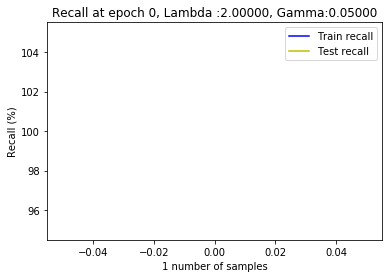

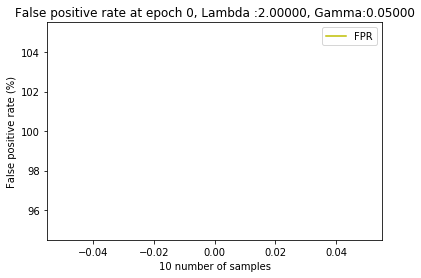

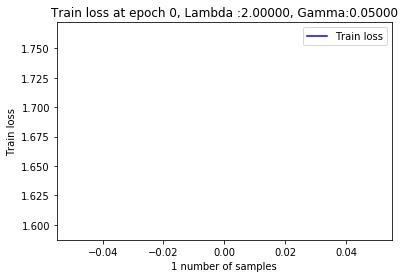

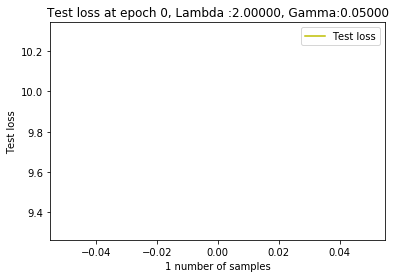

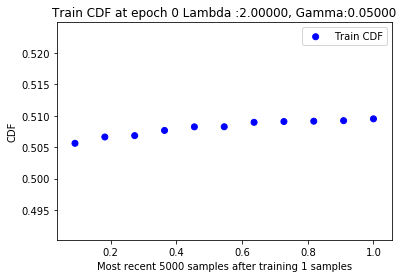

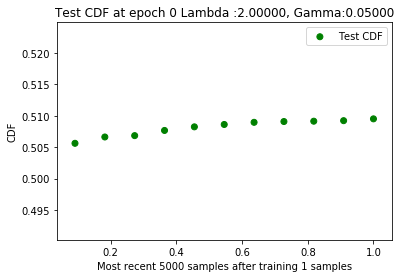

/home/yuhaowan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/yuhaowan/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


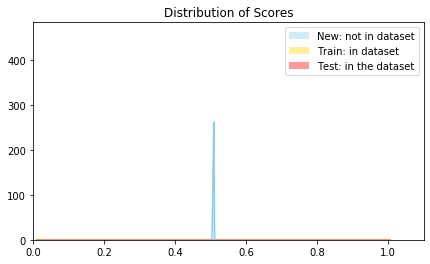

  0%|          | 2/480000 [02:41<15043:38:36, 112.83s/it]

New score:  0.5080821
Train score:  0.50809693
Test score:  0.5081299


  5%|▍         | 23846/480000 [47:22<15:15:28,  8.30it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  6%|▌         | 29948/480000 [58:07<14:38:04,  8.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  8%|▊         | 36929/480000 [1:10:22<27:07:44,  4.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variabl

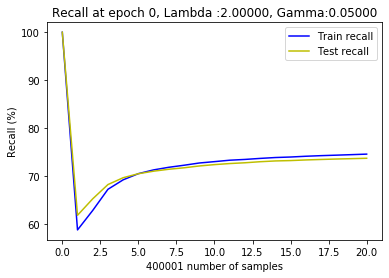

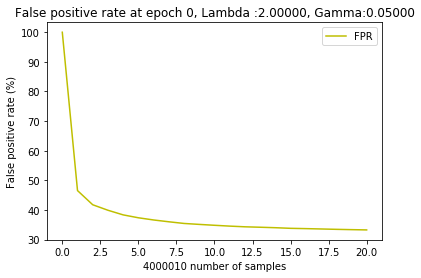

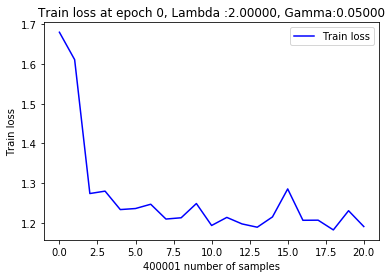

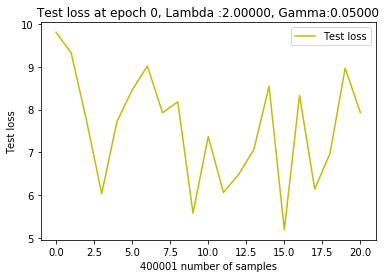

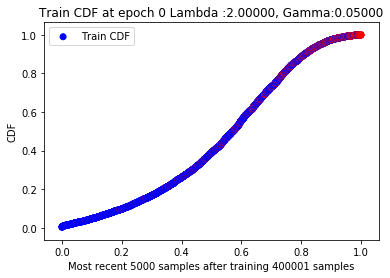

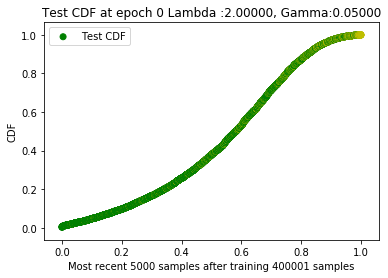

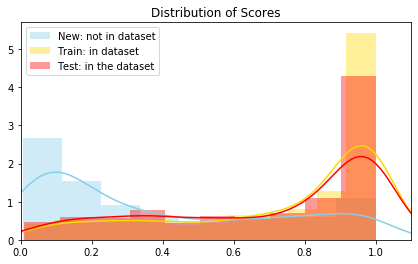

 83%|████████▎ | 400006/480000 [6:45:58<52:28:22,  2.36s/it]

New score:  0.3401238
Train score:  0.75817615
Test score:  0.72966635


  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  1  with learning rate:  [0.045125]


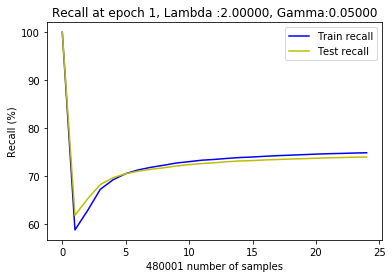

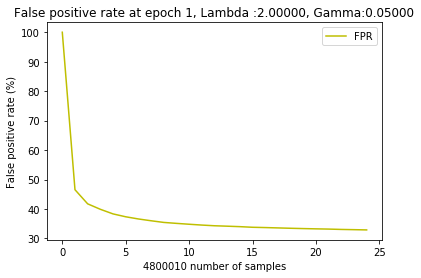

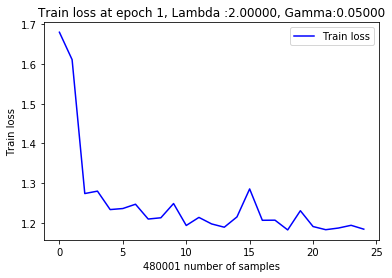

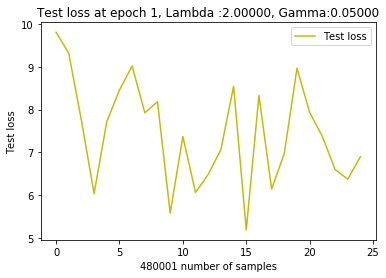

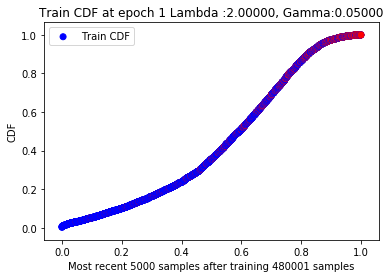

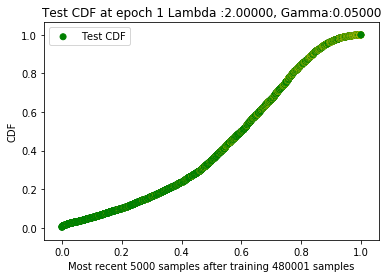

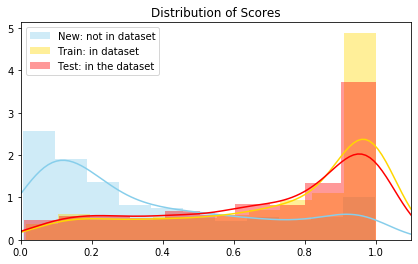

  0%|          | 6/480000 [00:55<5137:53:58, 38.53s/it]

New score:  0.34873047
Train score:  0.7234681
Test score:  0.7028451


 42%|████▏     | 200000/480000 [1:35:30<1:44:29, 44.66it/s]  

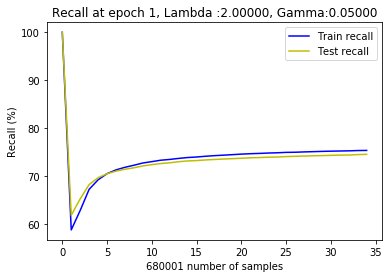

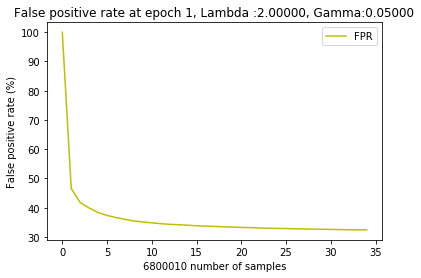

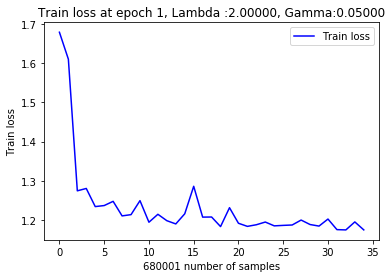

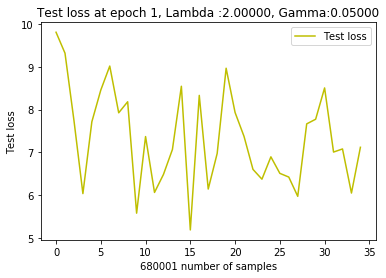

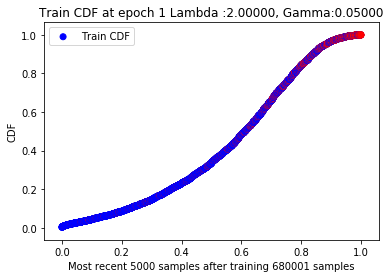

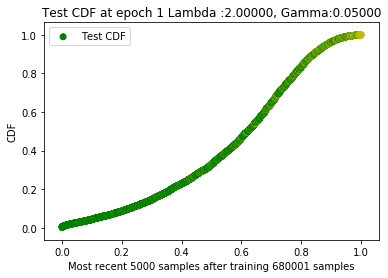

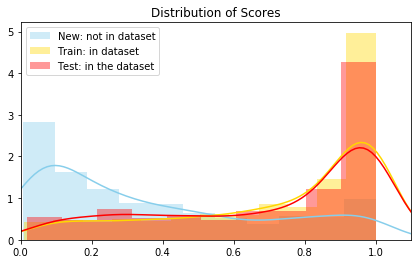

 42%|████▏     | 200006/480000 [1:36:15<929:04:14, 11.95s/it] 

New score:  0.37397826
Train score:  0.7406184
Test score:  0.709257


 83%|████████▎ | 399996/480000 [3:11:30<29:53, 44.60it/s]    

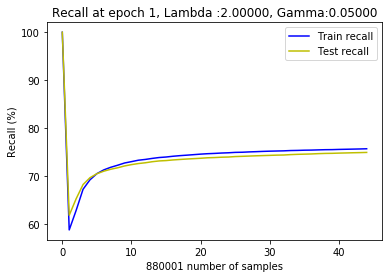

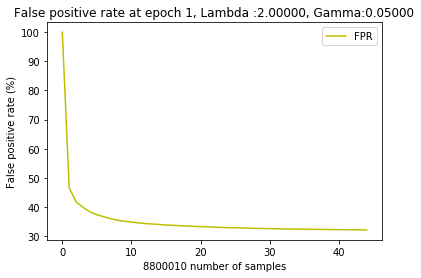

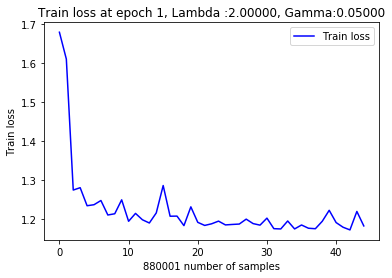

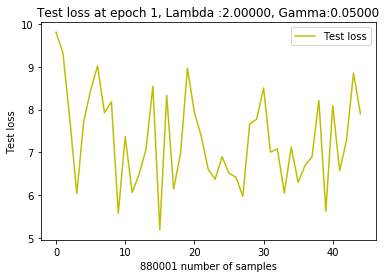

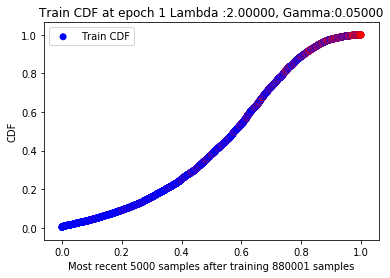

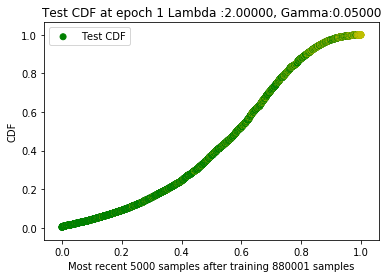

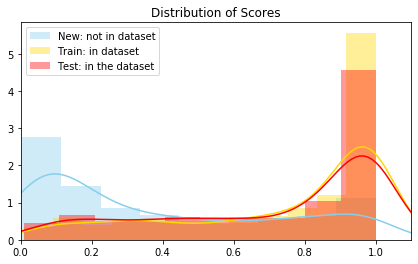

 83%|████████▎ | 400006/480000 [3:12:08<53:16:42,  2.40s/it]

New score:  0.341879
Train score:  0.76109874
Test score:  0.74054575


  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  2  with learning rate:  [0.0475]


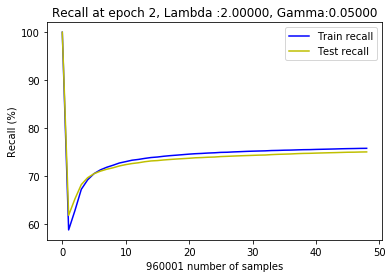

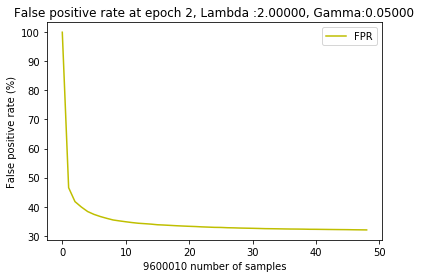

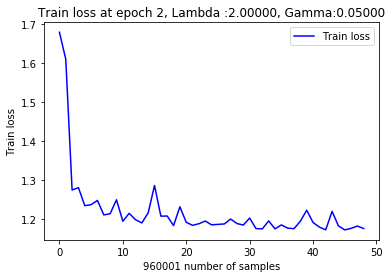

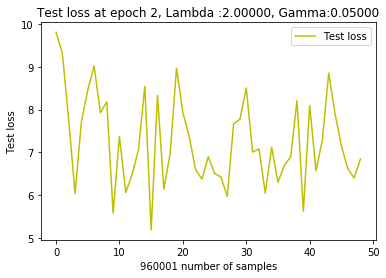

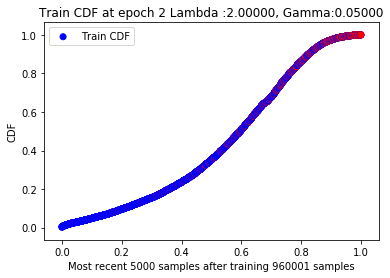

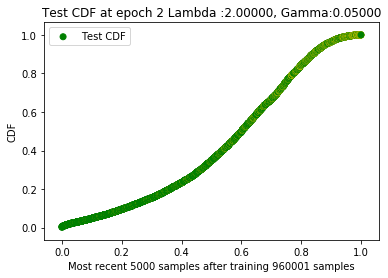

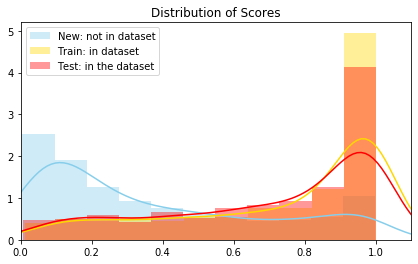

  0%|          | 6/480000 [00:55<5169:48:29, 38.77s/it]

New score:  0.34844643
Train score:  0.727291
Test score:  0.7119762


 42%|████▏     | 199997/480000 [1:36:10<1:44:23, 44.71it/s]  

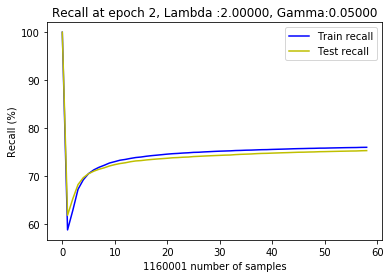

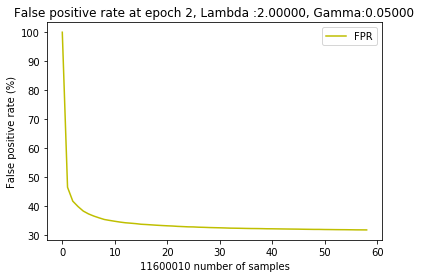

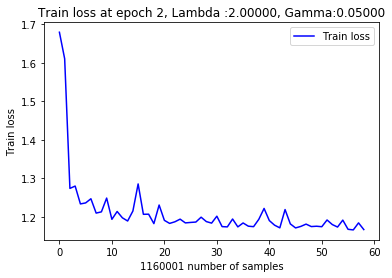

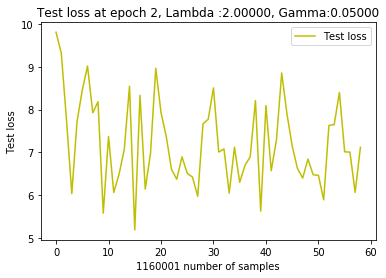

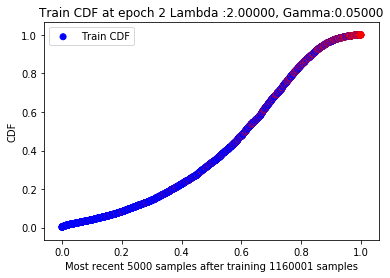

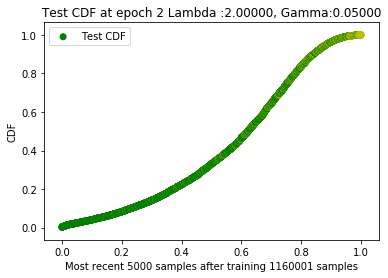

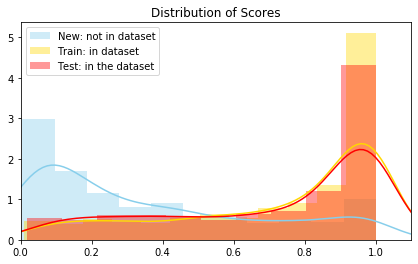

 42%|████▏     | 200006/480000 [1:36:53<232:12:51,  2.99s/it]

New score:  0.36203697
Train score:  0.742798
Test score:  0.7121148


 83%|████████▎ | 400000/480000 [3:11:50<29:17, 45.52it/s]    

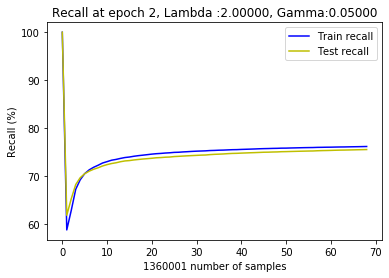

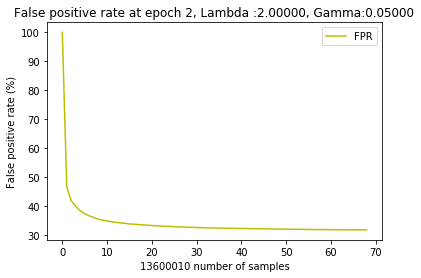

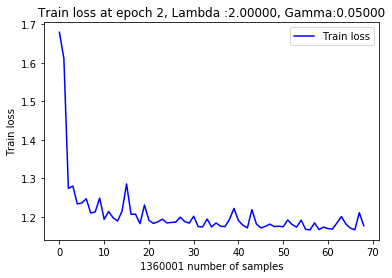

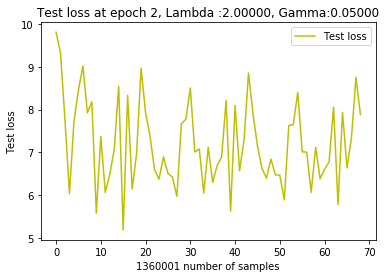

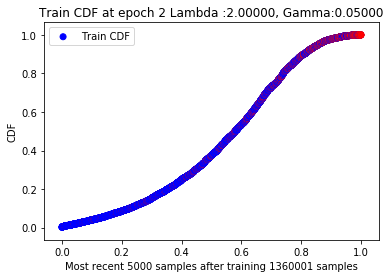

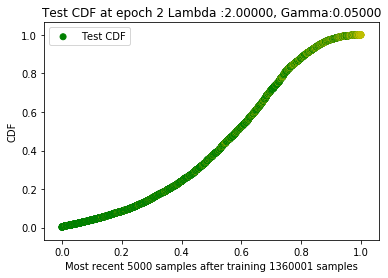

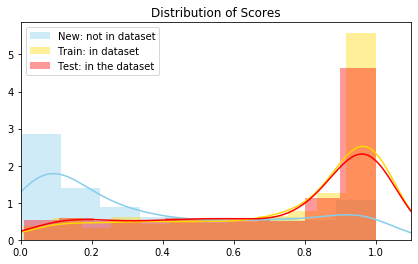

 83%|████████▎ | 400006/480000 [3:12:33<262:02:09, 11.79s/it]

New score:  0.33873808
Train score:  0.76353246
Test score:  0.7471505


  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  3  with learning rate:  [0.04286875]


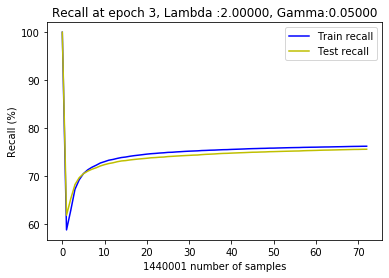

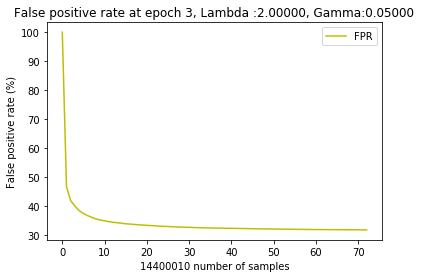

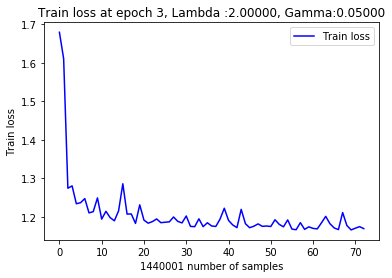

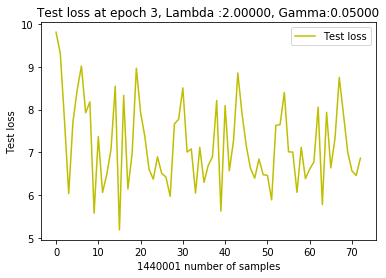

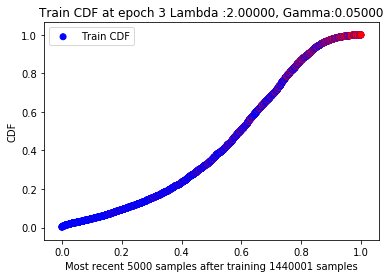

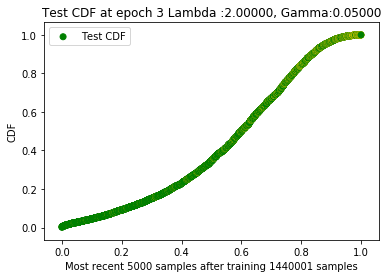

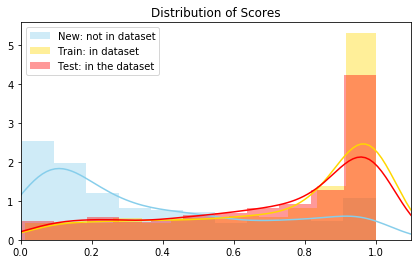

  0%|          | 6/480000 [00:55<5171:39:46, 38.79s/it]

New score:  0.35063908
Train score:  0.73026747
Test score:  0.716105


 42%|████▏     | 199998/480000 [1:35:40<1:42:58, 45.32it/s]  

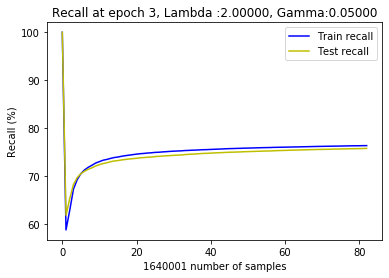

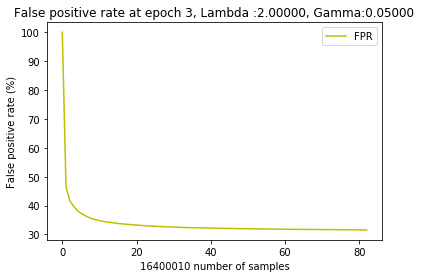

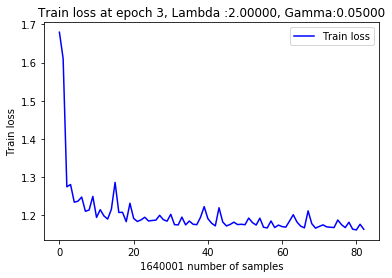

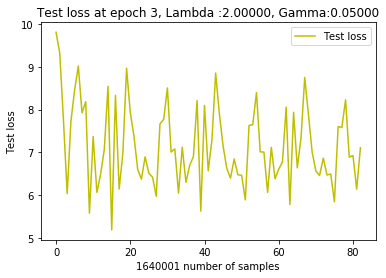

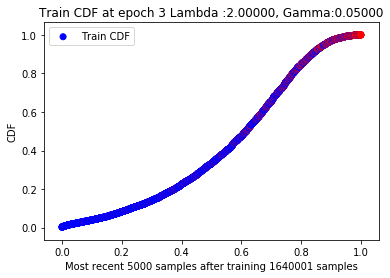

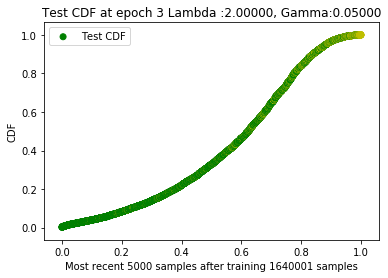

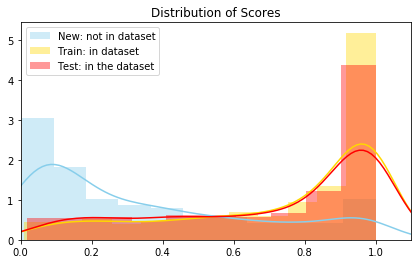

 42%|████▏     | 200006/480000 [1:36:16<303:54:50,  3.91s/it]

New score:  0.3531677
Train score:  0.7454376
Test score:  0.7147679


 83%|████████▎ | 399996/480000 [3:11:30<30:04, 44.33it/s]    

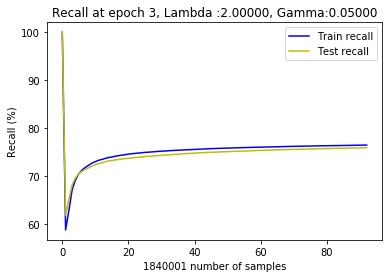

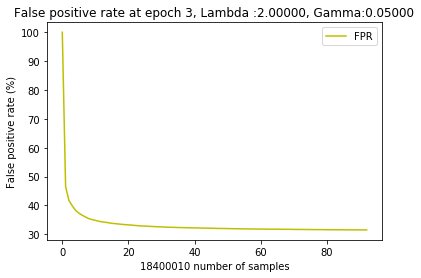

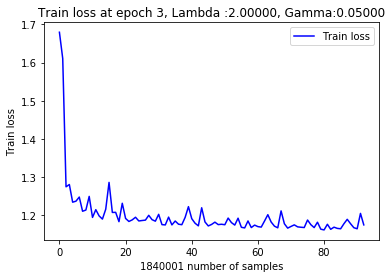

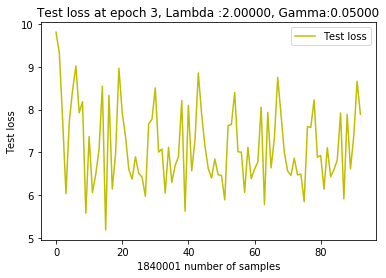

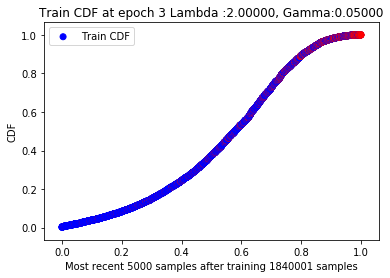

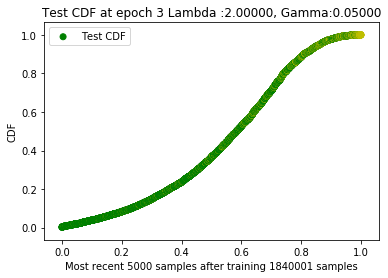

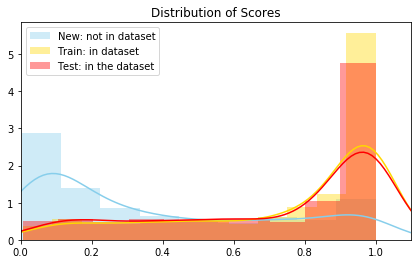

 83%|████████▎ | 400006/480000 [3:12:10<53:38:49,  2.41s/it]

New score:  0.3372733
Train score:  0.7655714
Test score:  0.75187546


  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  4  with learning rate:  [0.045125]


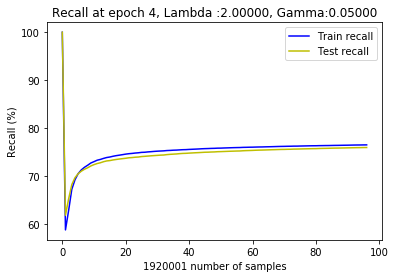

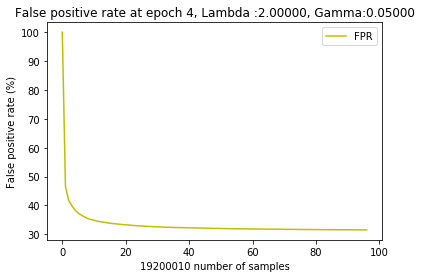

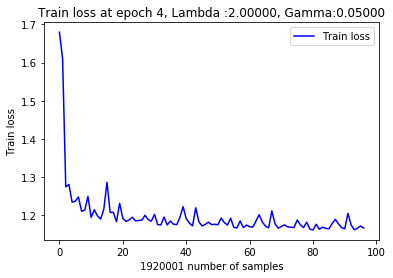

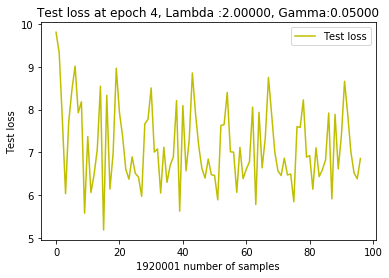

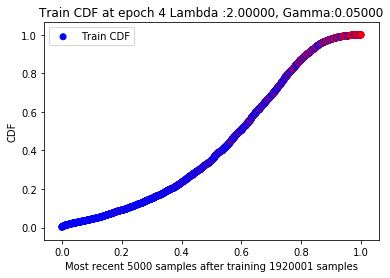

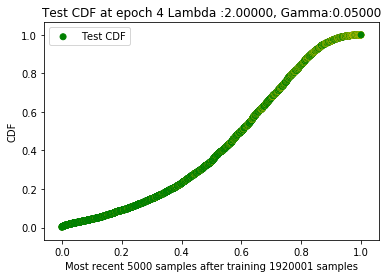

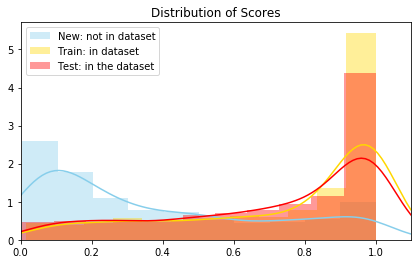

  0%|          | 6/480000 [00:56<5259:50:14, 39.45s/it]

New score:  0.35223228
Train score:  0.73305005
Test score:  0.71898866


 42%|████▏     | 199999/480000 [1:38:50<1:45:26, 44.26it/s]   

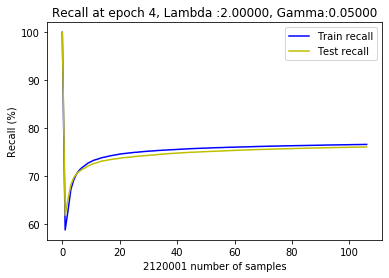

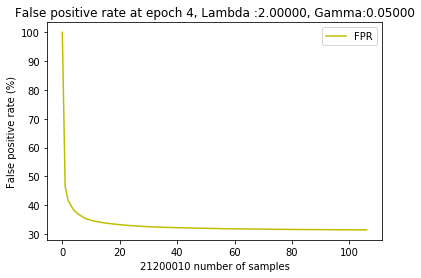

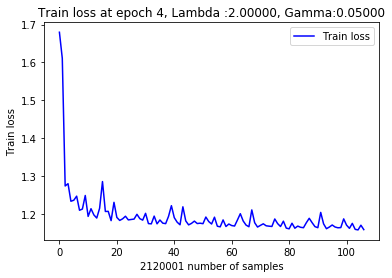

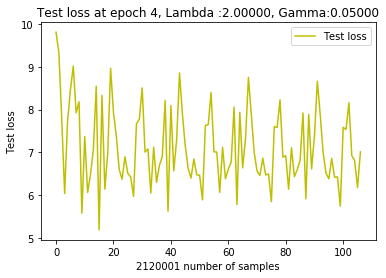

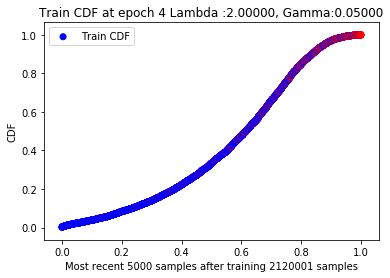

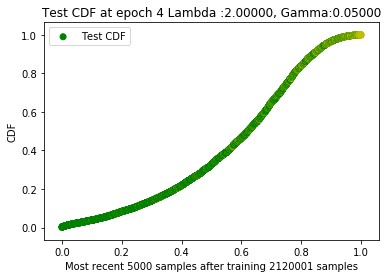

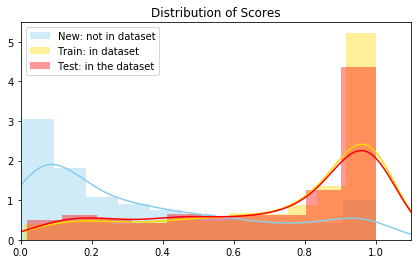

 42%|████▏     | 200006/480000 [1:39:28<464:23:16,  5.97s/it]

New score:  0.34779564
Train score:  0.74684036
Test score:  0.7173992


 83%|████████▎ | 399996/480000 [3:15:10<29:31, 45.17it/s]    

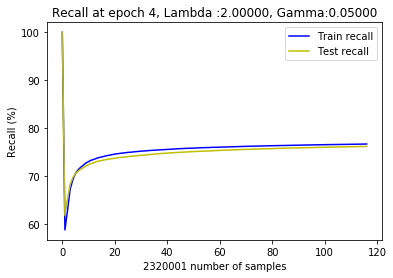

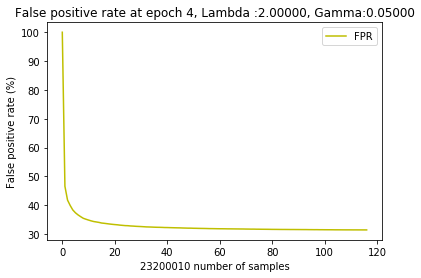

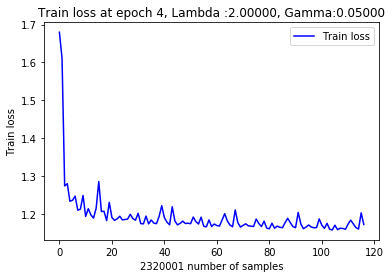

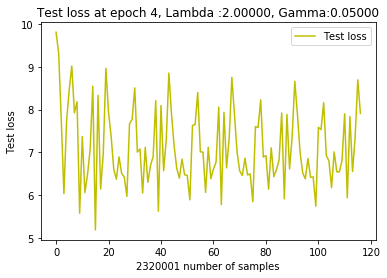

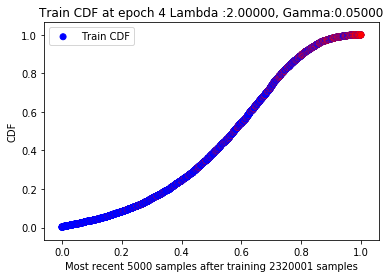

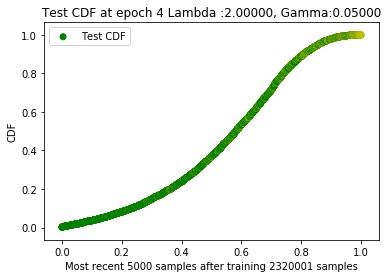

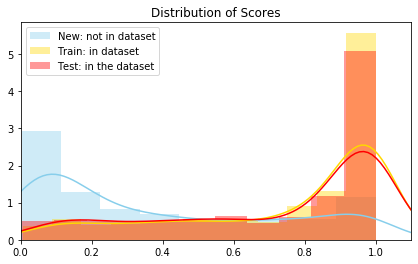

 83%|████████▎ | 400006/480000 [3:15:52<52:22:14,  2.36s/it]

New score:  0.34195787
Train score:  0.7686127
Test score:  0.7561219


  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  5  with learning rate:  [0.04072531249999999]


  2%|▏         | 9121/480000 [08:35<5:10:22, 25.29it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 10%|█         | 50358/480000 [41:29<4:15:58, 27.97it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▍        | 66534/480000 [54:26<4:28:07, 25.70it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable

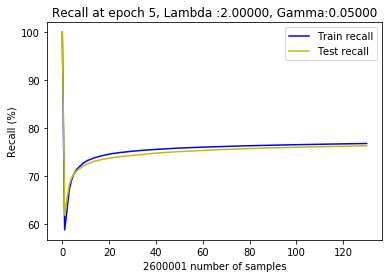

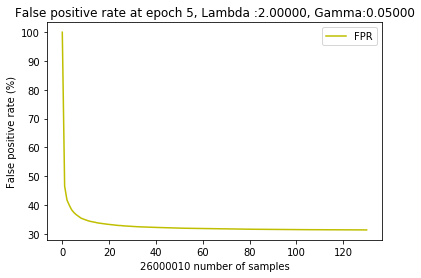

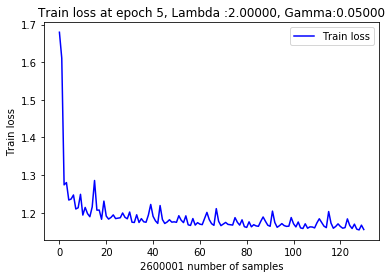

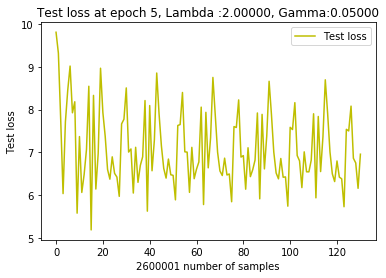

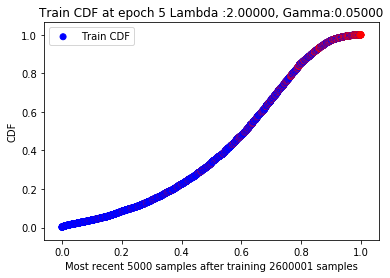

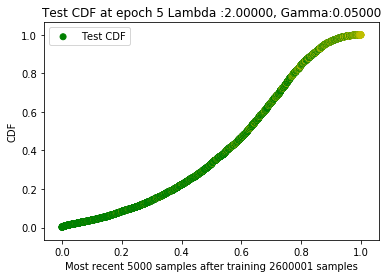

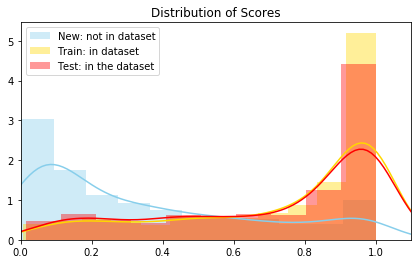

 42%|████▏     | 200006/480000 [2:35:37<469:32:01,  6.04s/it]

New score:  0.34683558
Train score:  0.74973106
Test score:  0.7205556


 83%|████████▎ | 400000/480000 [4:16:50<29:56, 44.52it/s]    

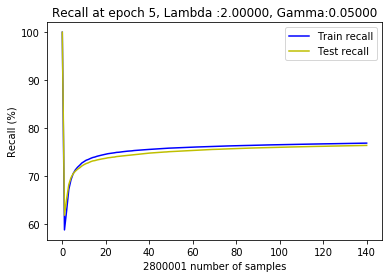

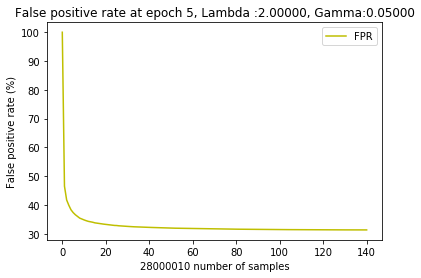

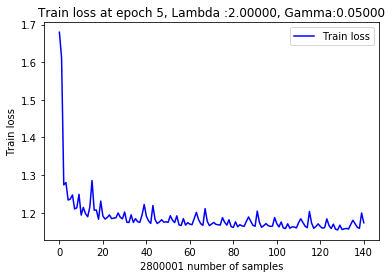

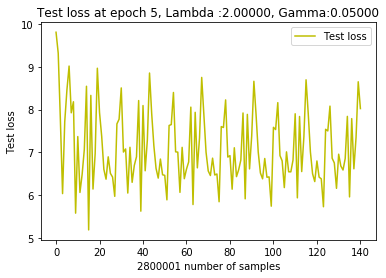

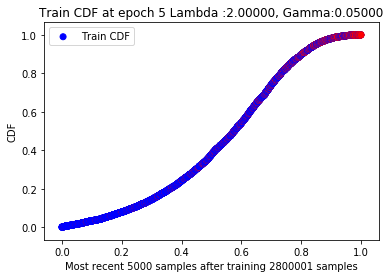

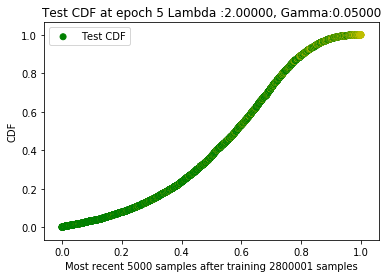

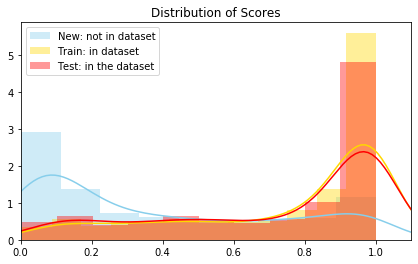

 83%|████████▎ | 400006/480000 [4:17:32<265:28:46, 11.95s/it]

New score:  0.34519452
Train score:  0.7715397
Test score:  0.75824946


  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  6  with learning rate:  [0.04286875]


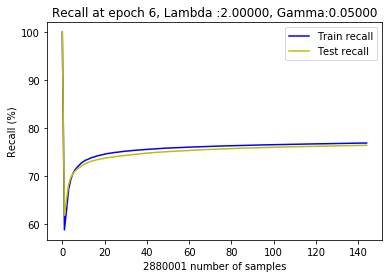

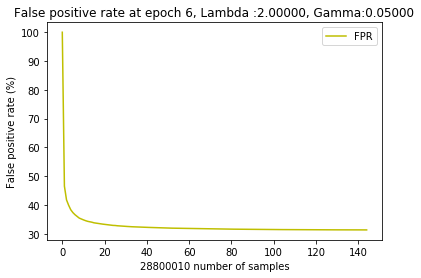

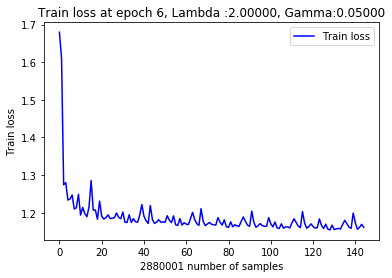

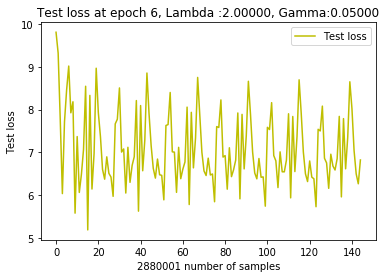

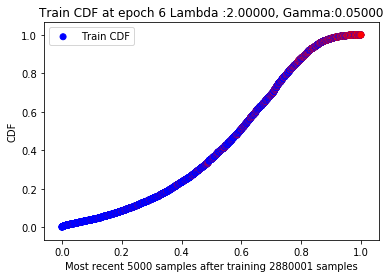

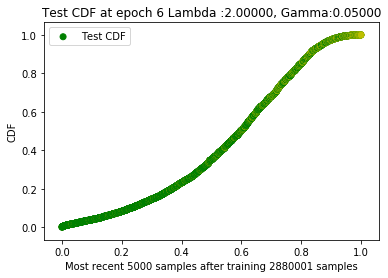

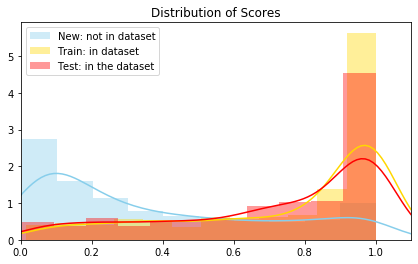

  0%|          | 6/480000 [00:56<5262:38:51, 39.47s/it]

New score:  0.35226277
Train score:  0.7390389
Test score:  0.7274548


 42%|████▏     | 199997/480000 [1:41:20<1:54:35, 40.72it/s]   

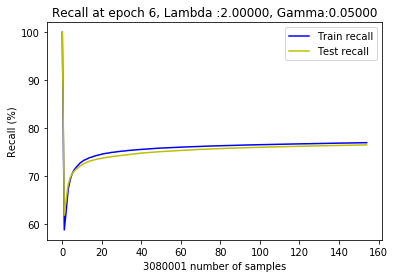

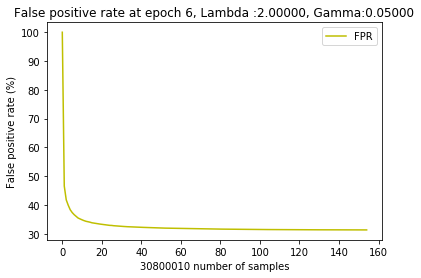

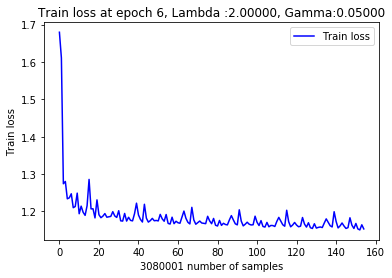

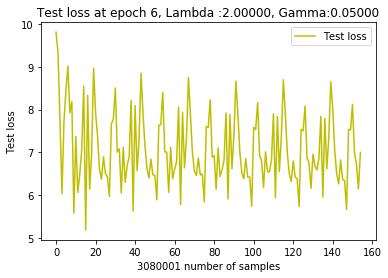

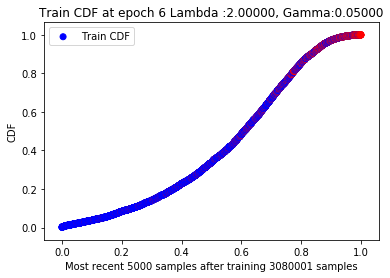

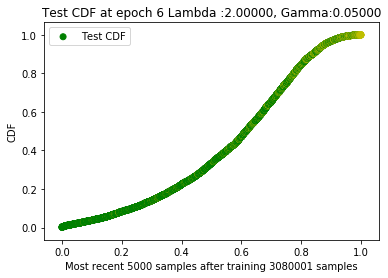

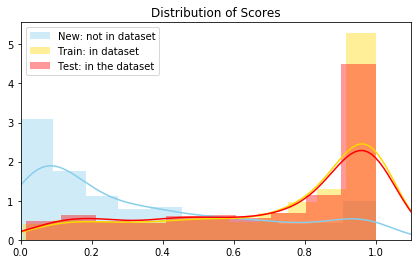

 42%|████▏     | 200005/480000 [1:42:05<252:27:12,  3.25s/it]

New score:  0.34688
Train score:  0.75266784
Test score:  0.72144336


 83%|████████▎ | 400000/480000 [3:28:30<34:21, 38.81it/s]     

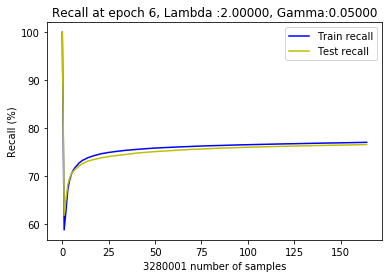

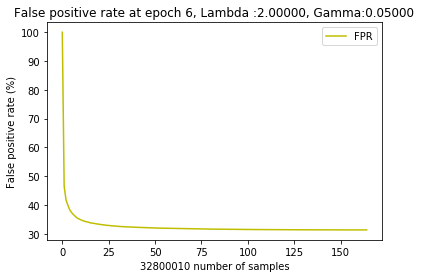

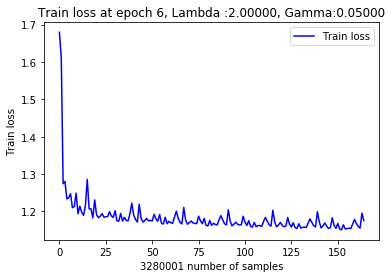

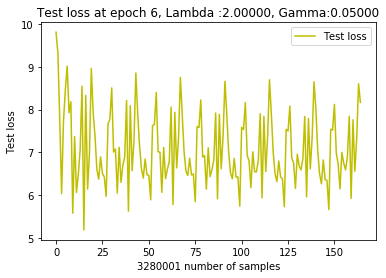

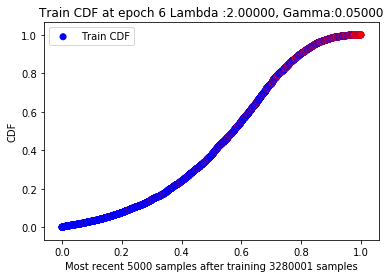

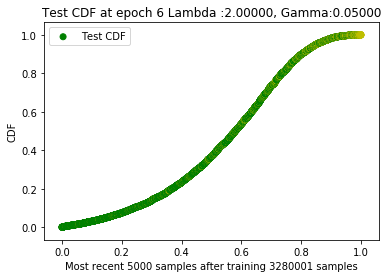

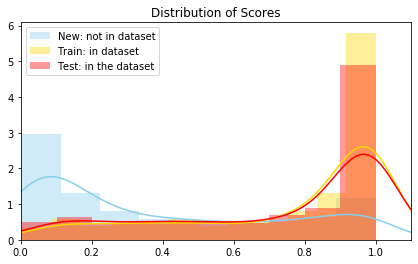

 83%|████████▎ | 400006/480000 [3:29:13<282:14:20, 12.70s/it]

New score:  0.34228024
Train score:  0.7741817
Test score:  0.76143557


  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  7  with learning rate:  [0.038689046874999994]


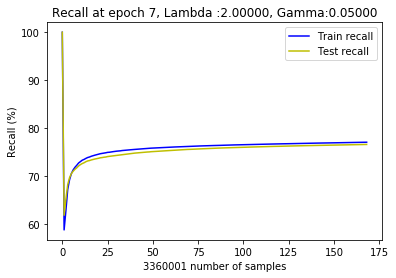

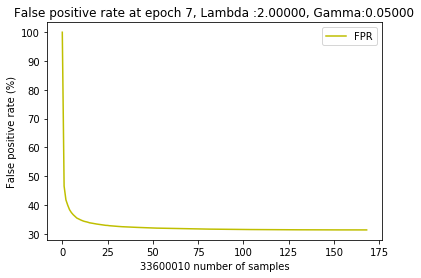

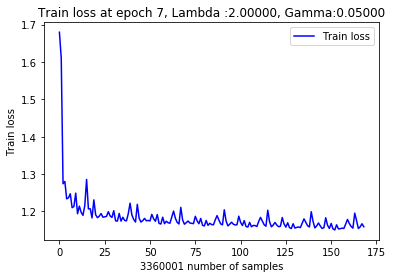

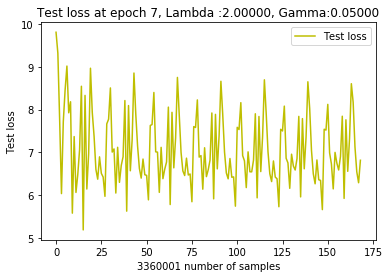

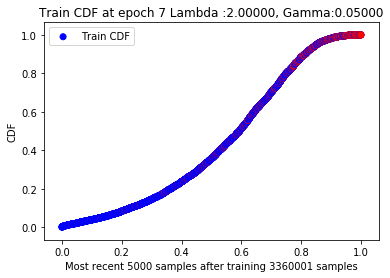

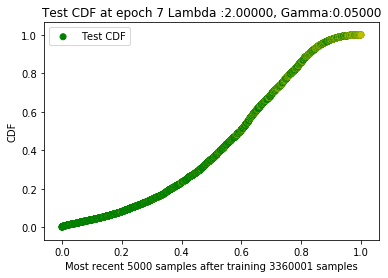

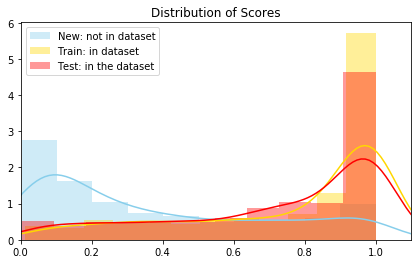

  0%|          | 5/480000 [00:59<5546:31:16, 41.60s/it]

New score:  0.35298595
Train score:  0.7424051
Test score:  0.73184764


 42%|████▏     | 199998/480000 [1:53:10<2:11:09, 35.58it/s]   

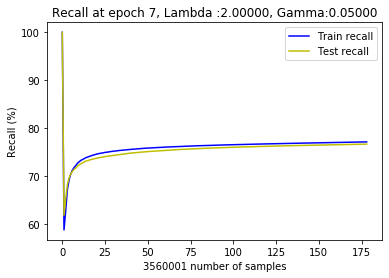

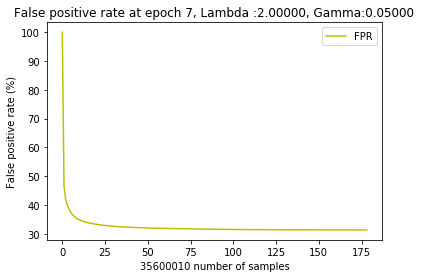

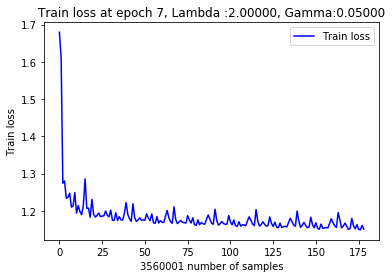

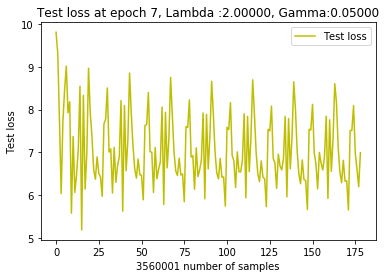

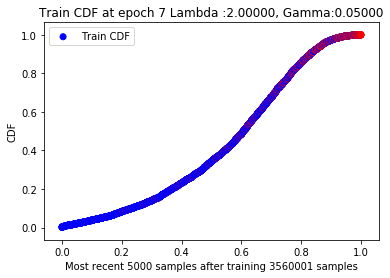

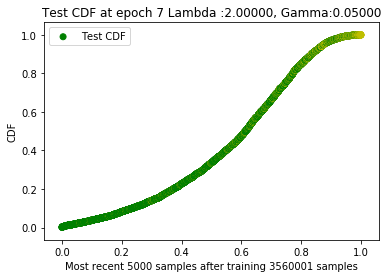

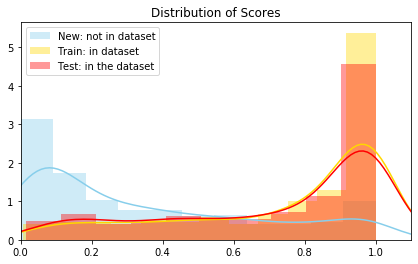

 42%|████▏     | 200005/480000 [1:54:04<362:41:17,  4.66s/it]

New score:  0.34698653
Train score:  0.7559534
Test score:  0.72483706


 83%|████████▎ | 399997/480000 [3:44:10<32:01, 41.64it/s]    

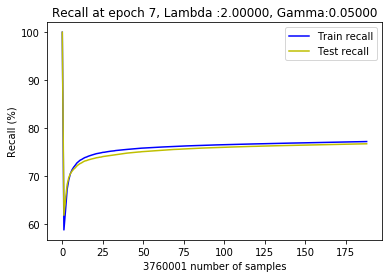

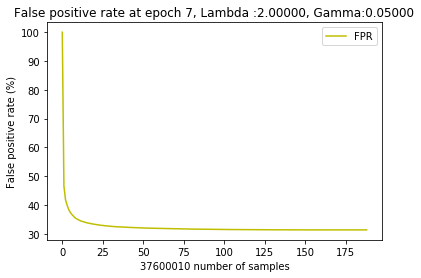

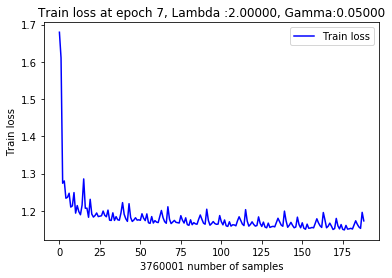

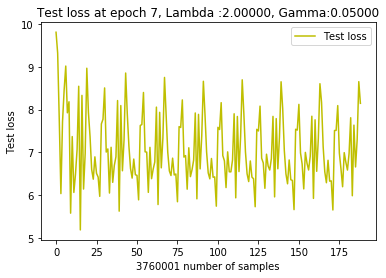

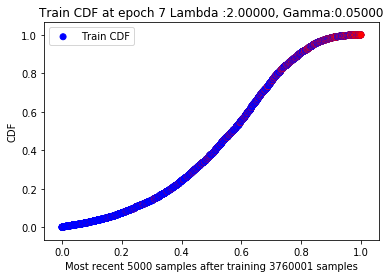

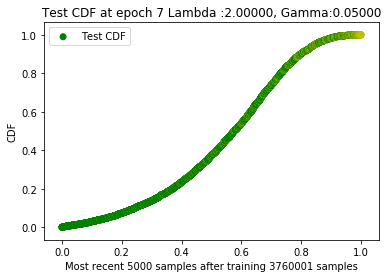

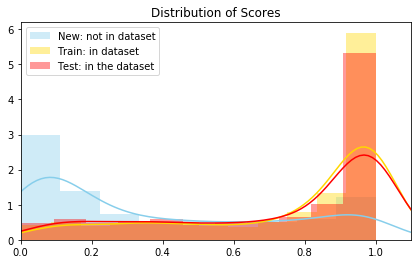

 83%|████████▎ | 400006/480000 [3:44:51<69:02:52,  3.11s/it]

New score:  0.34257904
Train score:  0.77695376
Test score:  0.76434


  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  8  with learning rate:  [0.04072531249999999]


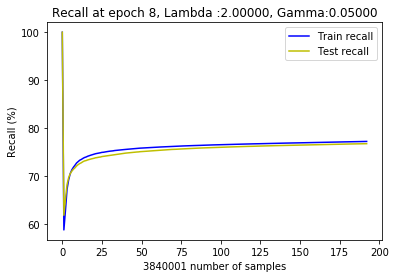

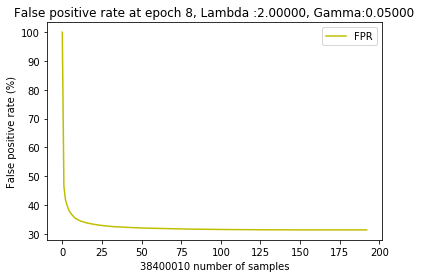

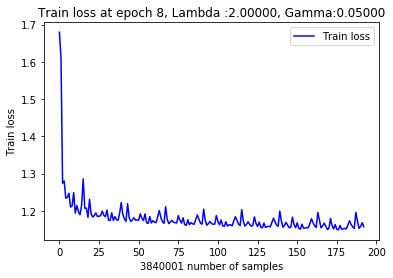

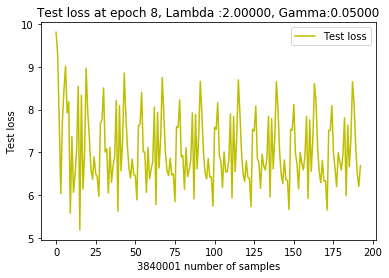

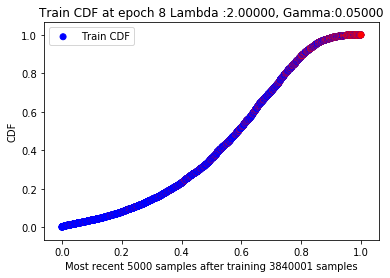

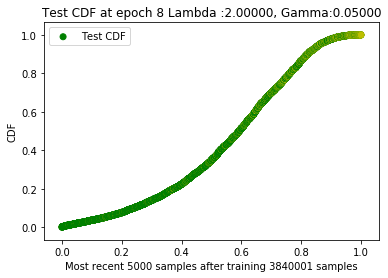

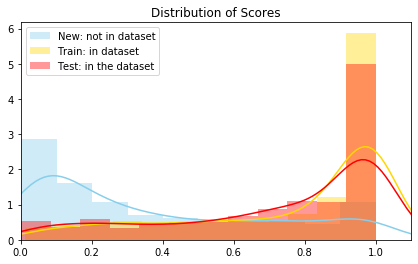

  0%|          | 6/480000 [00:57<5339:43:08, 40.05s/it]

New score:  0.34591526
Train score:  0.746918
Test score:  0.73522353


 42%|████▏     | 199997/480000 [1:41:00<1:47:35, 43.37it/s]   

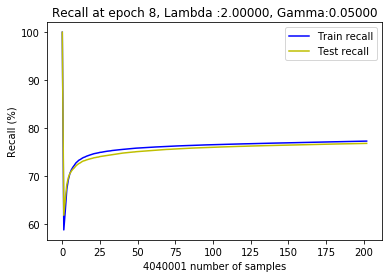

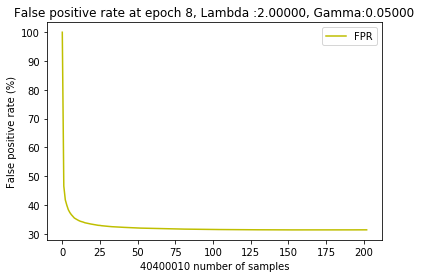

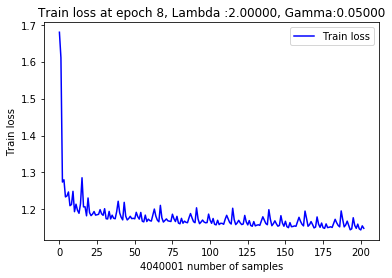

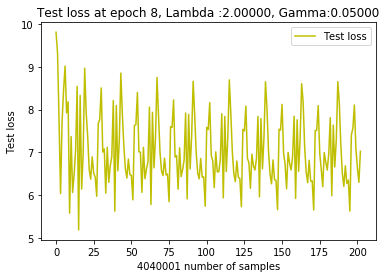

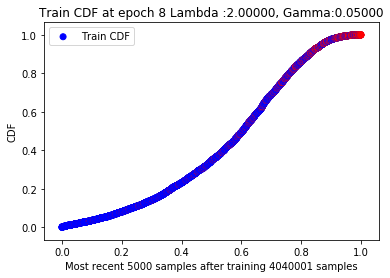

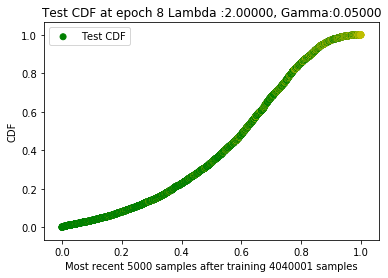

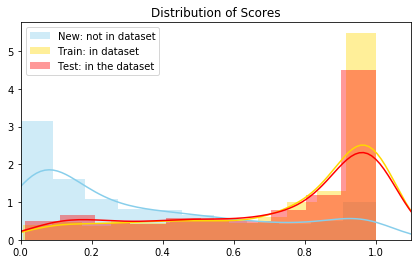

 42%|████▏     | 200006/480000 [1:41:47<236:26:00,  3.04s/it]

New score:  0.348638
Train score:  0.76020473
Test score:  0.72703904


 83%|████████▎ | 399997/480000 [3:23:00<32:00, 41.66it/s]     

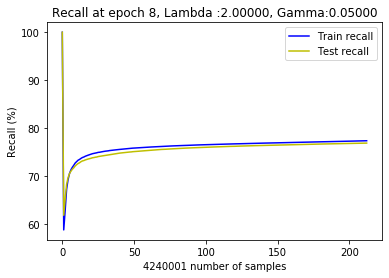

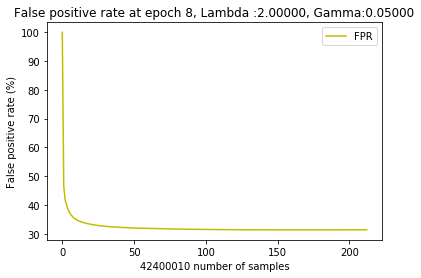

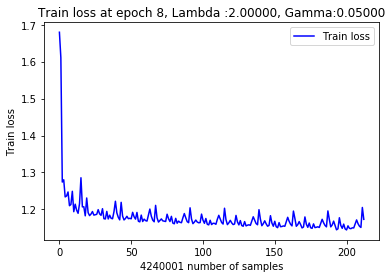

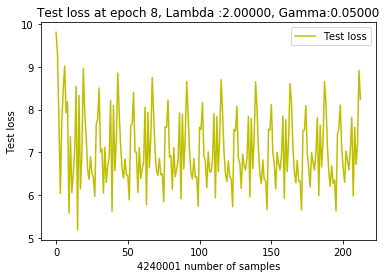

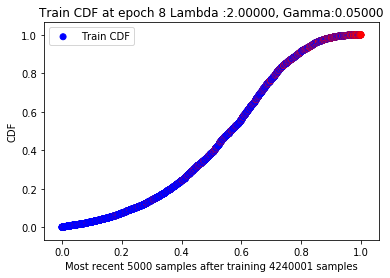

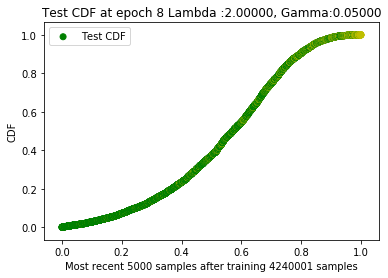

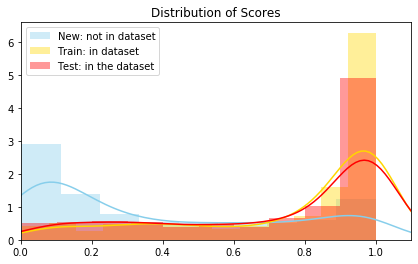

 83%|████████▎ | 400005/480000 [3:23:47<68:52:58,  3.10s/it]

New score:  0.35084432
Train score:  0.7808026
Test score:  0.76683146


  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  9  with learning rate:  [0.03675459453124999]


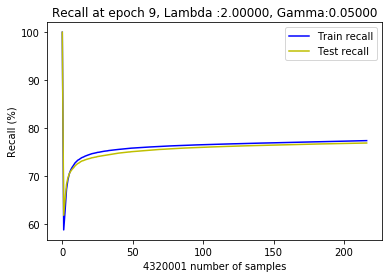

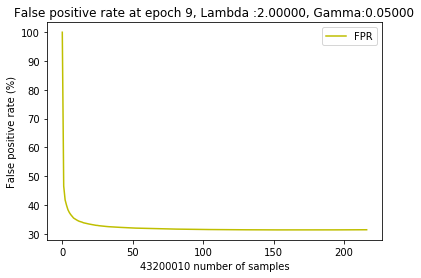

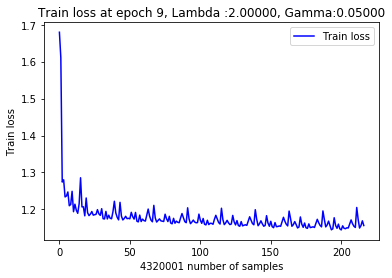

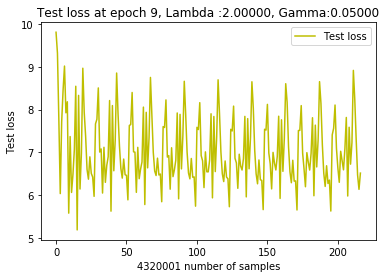

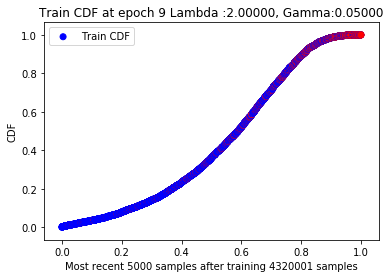

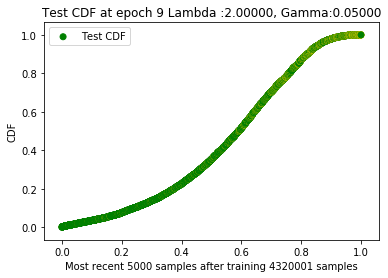

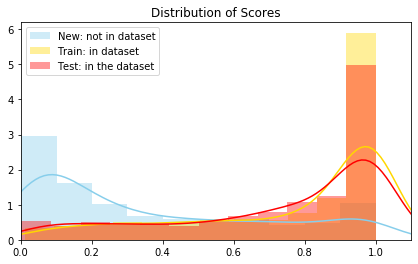

  0%|          | 6/480000 [00:58<5454:43:04, 40.91s/it]

New score:  0.3363409
Train score:  0.7474936
Test score:  0.73442054


 42%|████▏     | 199998/480000 [1:41:10<1:53:31, 41.11it/s]  

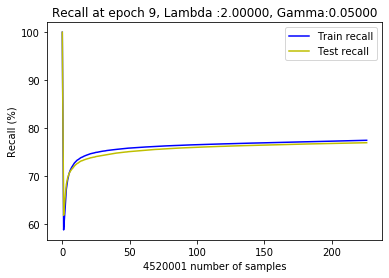

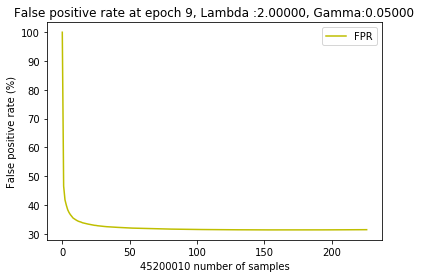

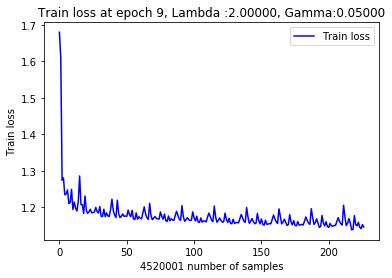

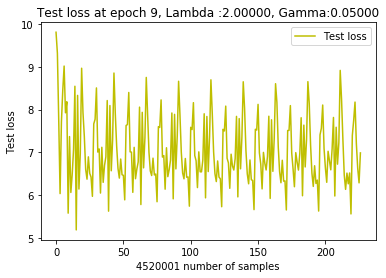

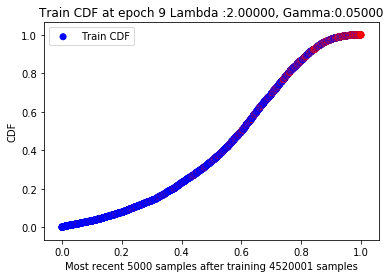

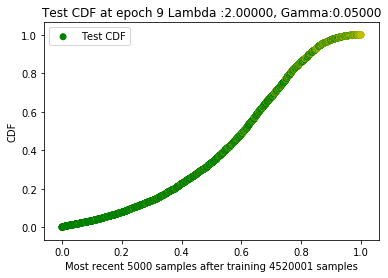

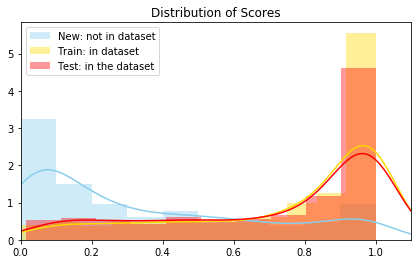

 42%|████▏     | 200006/480000 [1:41:53<317:57:41,  4.09s/it]

New score:  0.34114572
Train score:  0.76215017
Test score:  0.72503257


 65%|██████▍   | 310485/480000 [3:00:37<1:34:39, 29.85it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 71%|███████   | 339812/480000 [3:23:53<1:48:10, 21.60it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 77%|███████▋  | 370893/480000 [3:48:56<1:35:29, 19.04it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config va

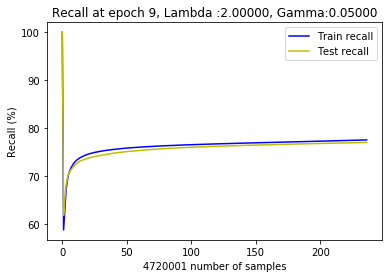

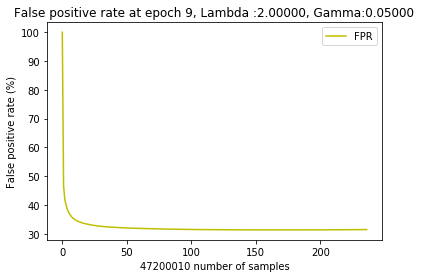

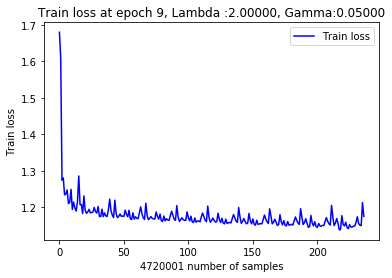

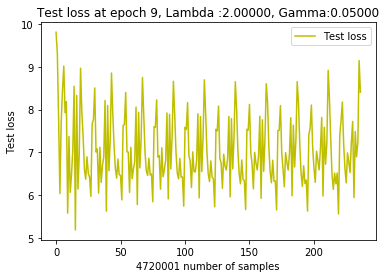

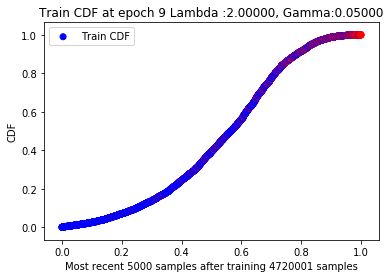

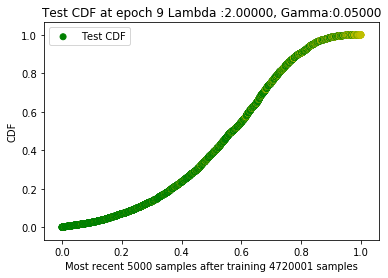

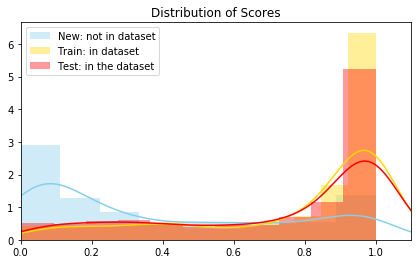

 83%|████████▎ | 400004/480000 [4:09:55<116:32:11,  5.24s/it]

New score:  0.3565791
Train score:  0.78536266
Test score:  0.76788175


 84%|████████▍ | 405276/480000 [4:13:08<42:36, 29.23it/s]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 91%|█████████▏| 438798/480000 [4:34:51<28:12, 24.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  10  with learning rate:  [0.038689046874999994]


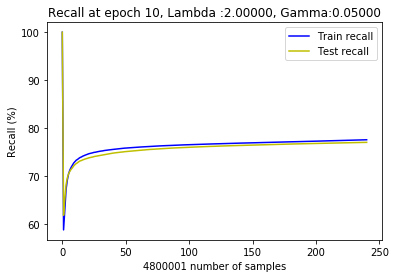

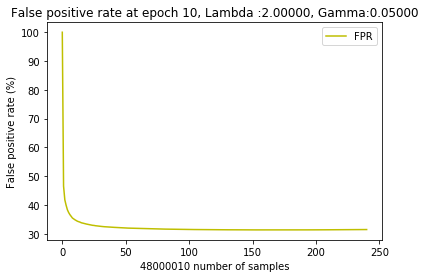

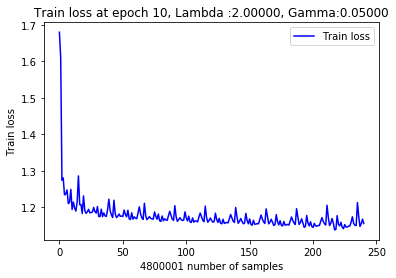

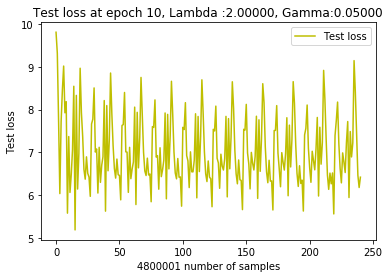

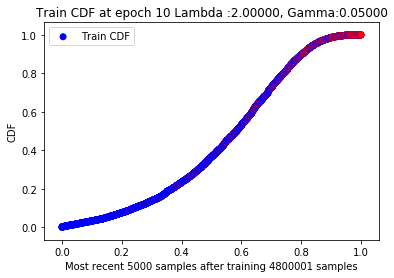

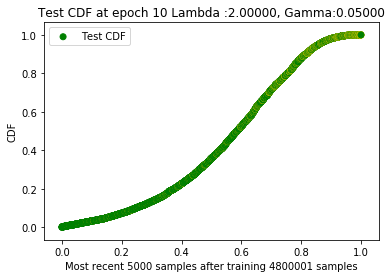

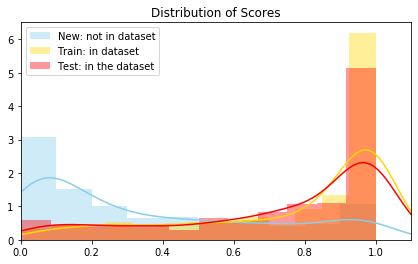

  0%|          | 4/480000 [01:14<6959:18:33, 52.20s/it]

New score:  0.33158746
Train score:  0.753531
Test score:  0.73577183


  2%|▏         | 7557/480000 [05:47<5:49:14, 22.55it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  8%|▊         | 40492/480000 [28:59<5:27:14, 22.38it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▍        | 66854/480000 [52:03<5:05:06, 22.57it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable

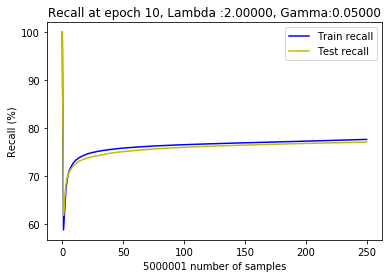

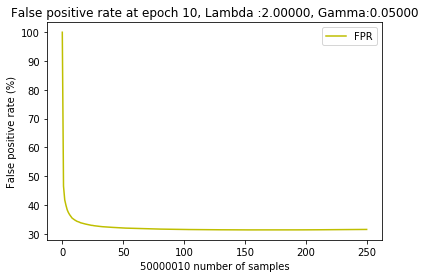

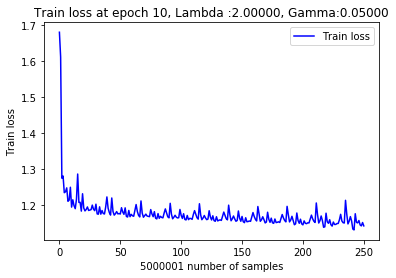

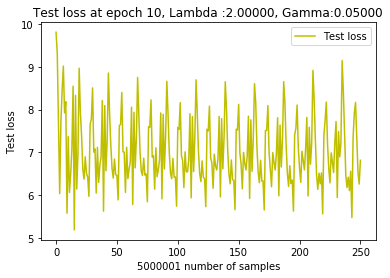

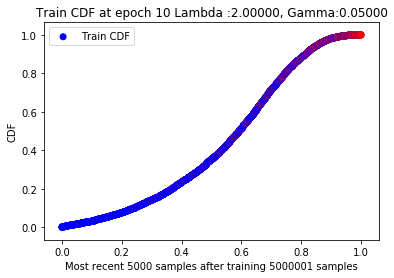

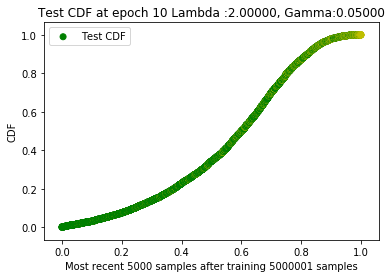

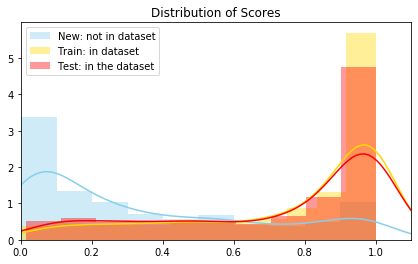

 42%|████▏     | 200004/480000 [2:50:12<1666:07:54, 21.42s/it]

New score:  0.34692153
Train score:  0.77023065
Test score:  0.7310493


 42%|████▏     | 201561/480000 [2:51:28<3:39:26, 21.15it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 47%|████▋     | 225895/480000 [3:11:25<2:18:51, 30.50it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 42%|████▏     | 200000/480000 [2:15:00<2:29:19, 31.25it/s]   

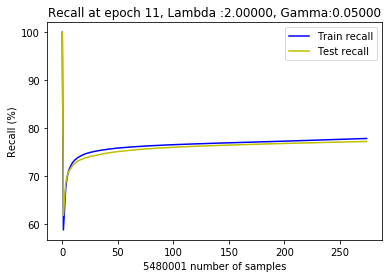

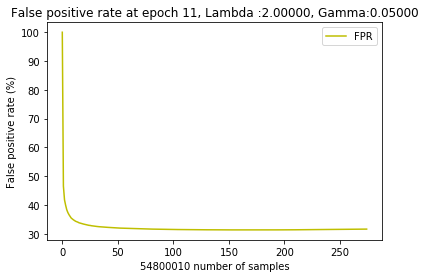

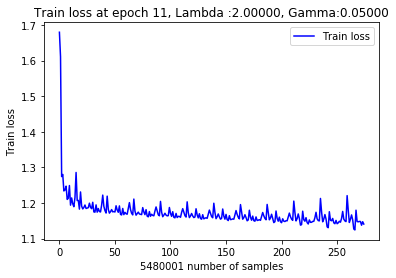

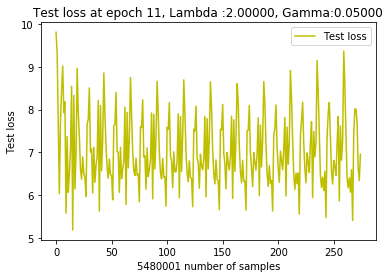

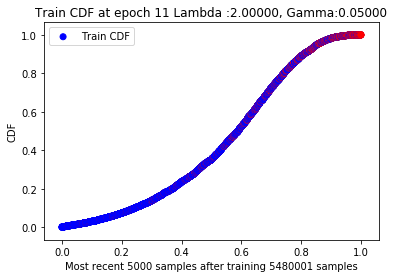

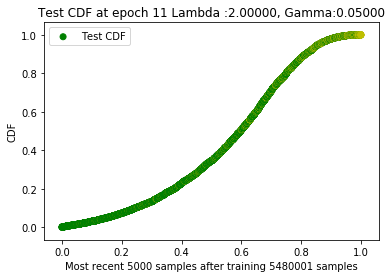

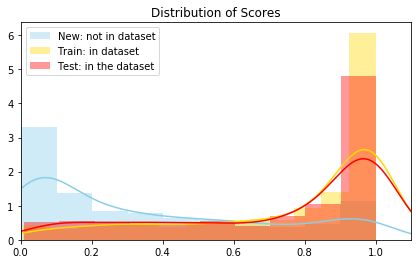

 42%|████▏     | 200005/480000 [2:15:58<1229:28:42, 15.81s/it]

New score:  0.35756975
Train score:  0.7712519
Test score:  0.7332322


 83%|████████▎ | 400000/480000 [4:31:00<43:05, 30.94it/s]     

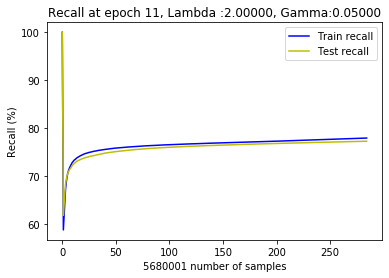

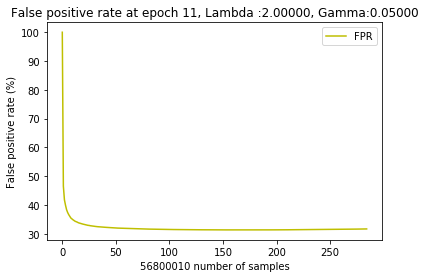

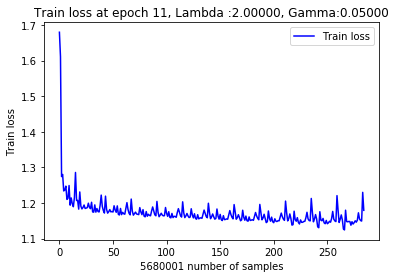

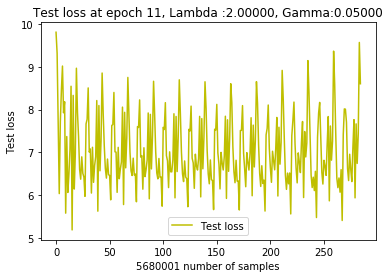

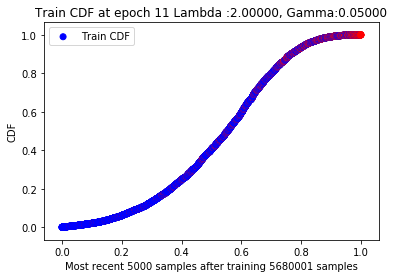

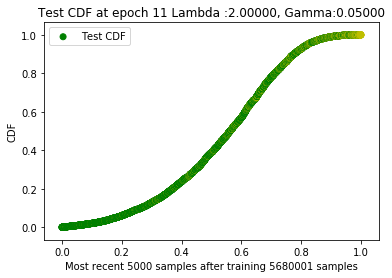

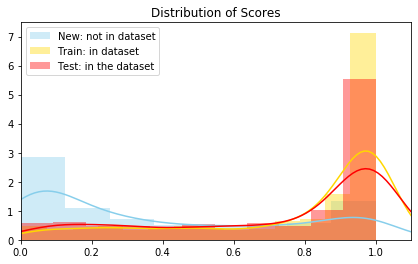

 83%|████████▎ | 400004/480000 [4:32:04<364:00:25, 16.38s/it]

New score:  0.3576045
Train score:  0.7919929
Test score:  0.7699606


  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  12  with learning rate:  [0.03675459453124999]


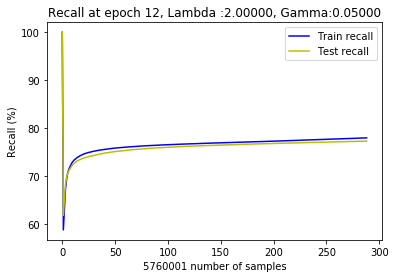

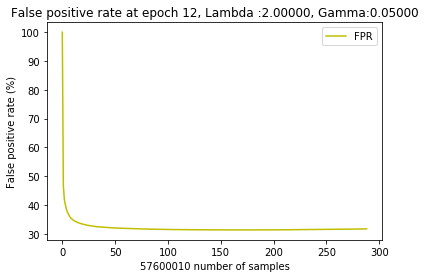

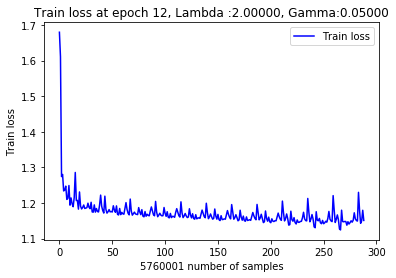

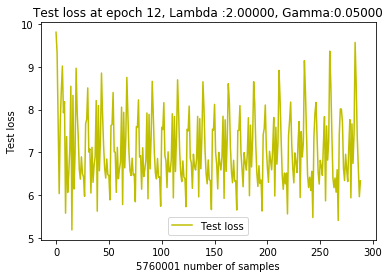

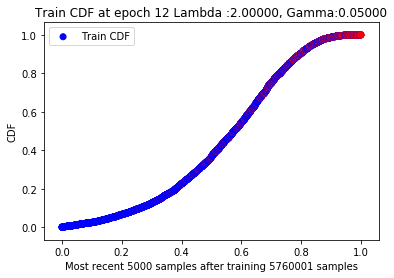

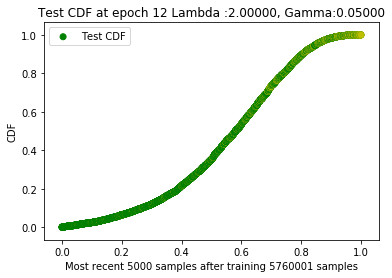

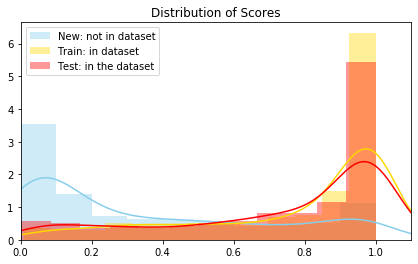

  0%|          | 4/480000 [01:12<6794:34:06, 50.96s/it]

New score:  0.32769895
Train score:  0.7607711
Test score:  0.7373909


 42%|████▏     | 199999/480000 [2:12:50<2:30:17, 31.05it/s]   

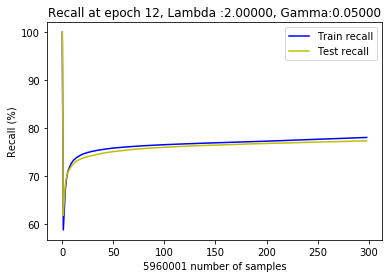

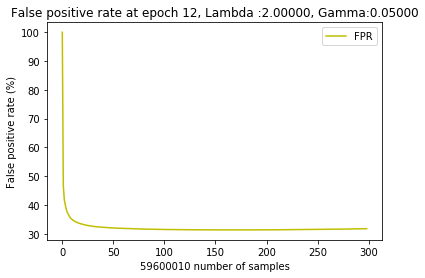

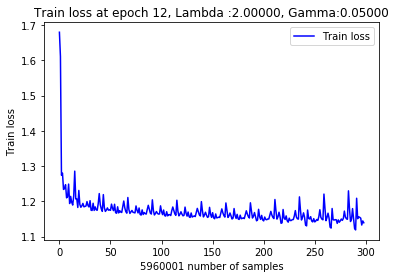

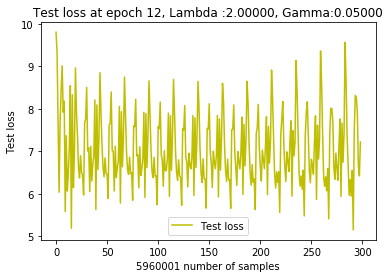

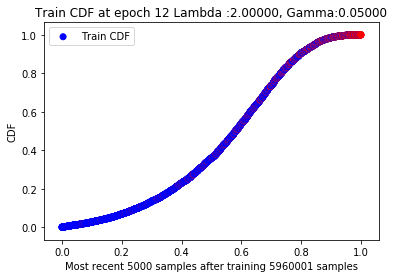

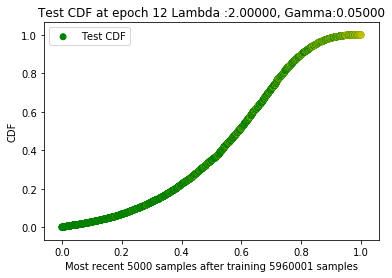

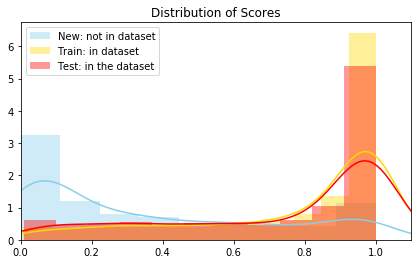

 42%|████▏     | 200004/480000 [2:13:48<595:41:25,  7.66s/it]

New score:  0.35995263
Train score:  0.77968305
Test score:  0.7368303


 83%|████████▎ | 400000/480000 [4:24:30<41:58, 31.77it/s]     

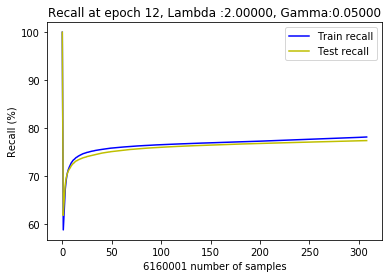

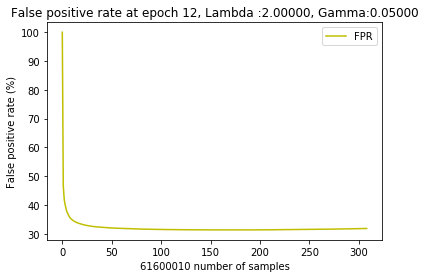

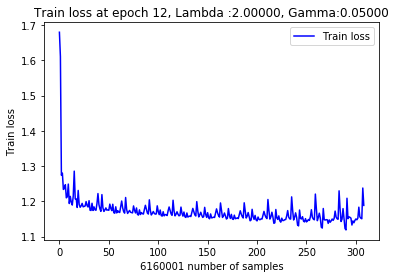

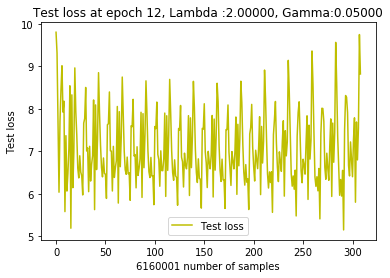

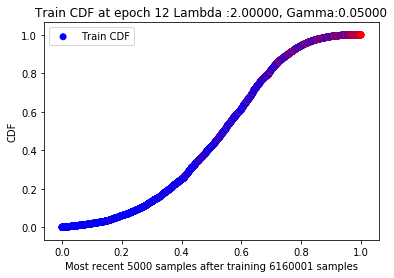

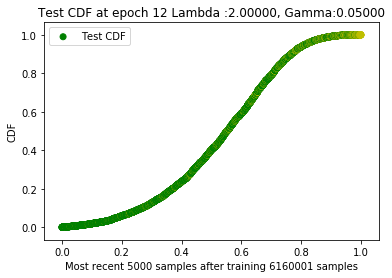

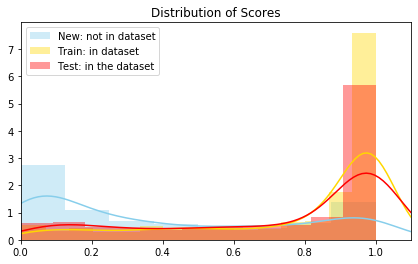

 83%|████████▎ | 400005/480000 [4:25:23<334:19:27, 15.05s/it]

New score:  0.38249305
Train score:  0.7957003
Test score:  0.76967055


  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  13  with learning rate:  [0.03317102156445311]


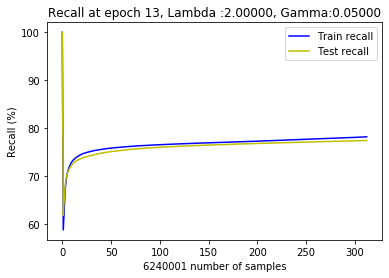

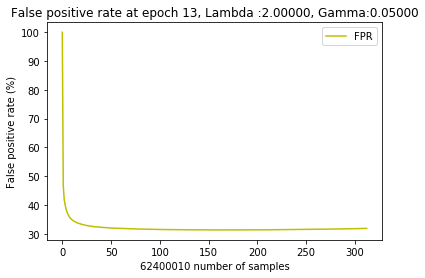

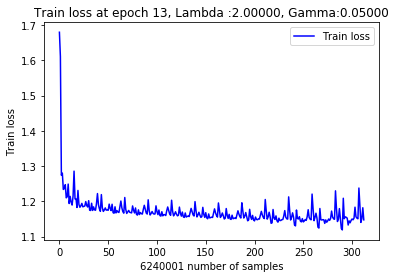

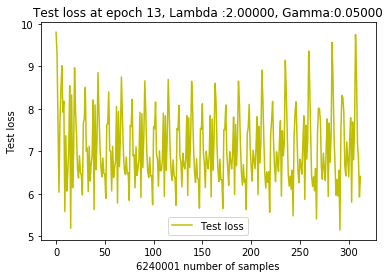

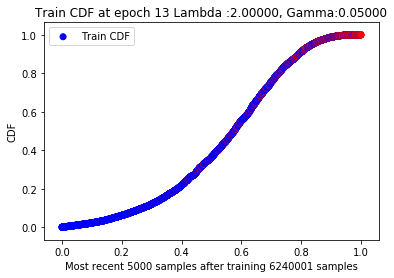

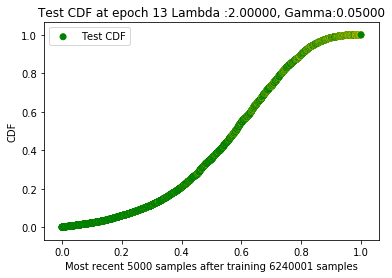

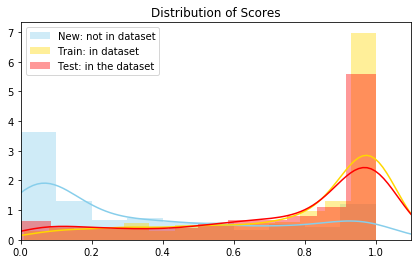

  0%|          | 5/480000 [01:11<6676:18:56, 50.07s/it]

New score:  0.33187196
Train score:  0.7644352
Test score:  0.7387112


 42%|████▏     | 199997/480000 [2:11:40<2:35:01, 30.10it/s]   

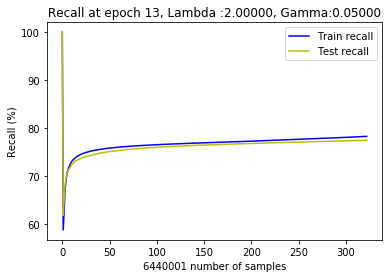

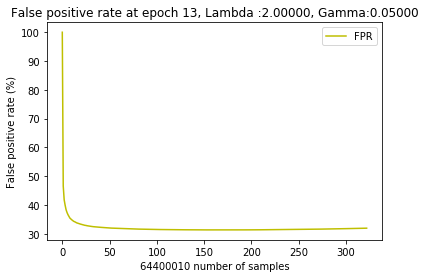

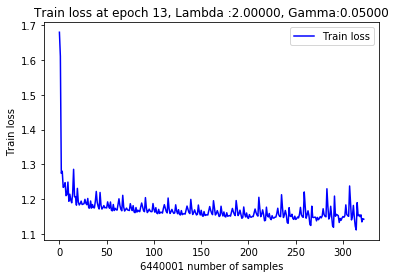

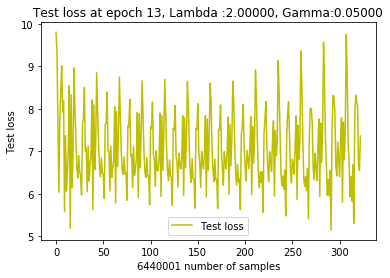

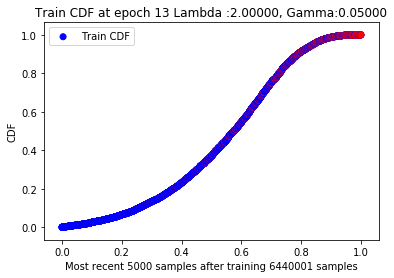

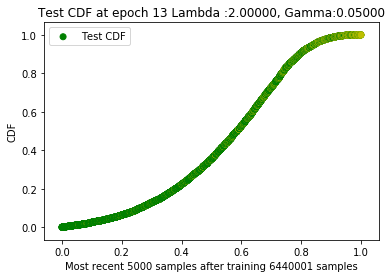

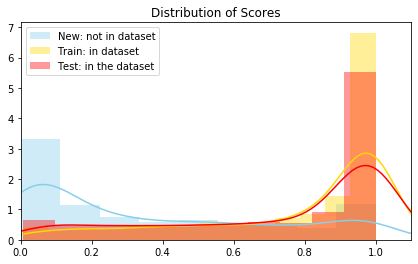

 42%|████▏     | 200005/480000 [2:12:38<298:03:08,  3.83s/it]

New score:  0.3642267
Train score:  0.78812647
Test score:  0.73929006


 83%|████████▎ | 399997/480000 [4:23:40<42:48, 31.14it/s]    

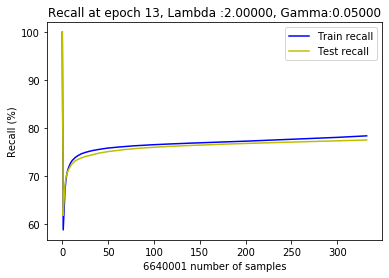

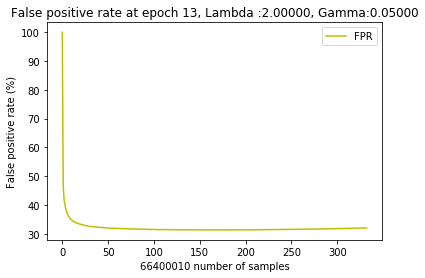

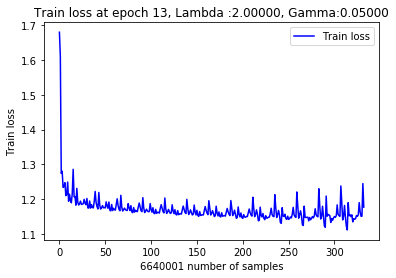

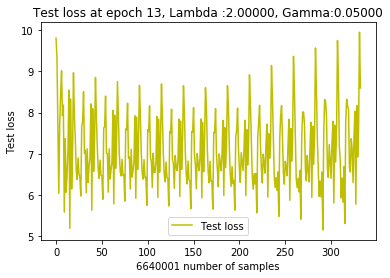

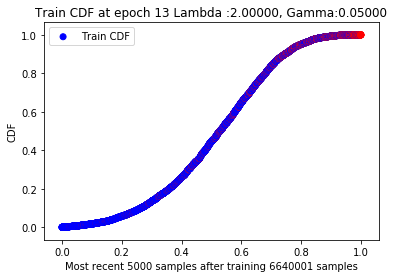

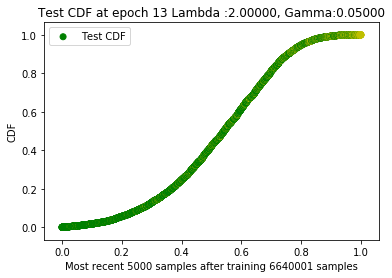

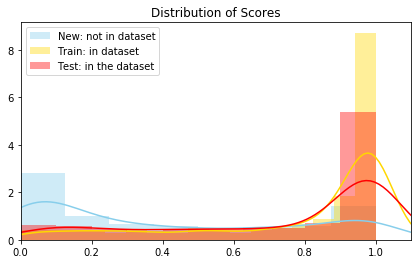

 83%|████████▎ | 400004/480000 [4:24:42<89:17:46,  4.02s/it] 

New score:  0.38628954
Train score:  0.80596495
Test score:  0.77819264


  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  14  with learning rate:  [0.03491686480468749]


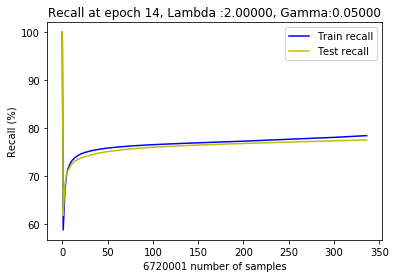

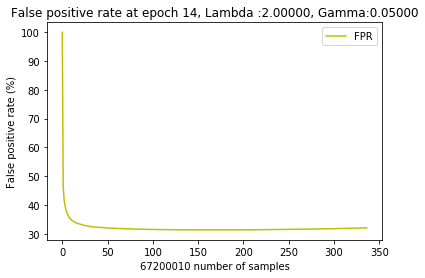

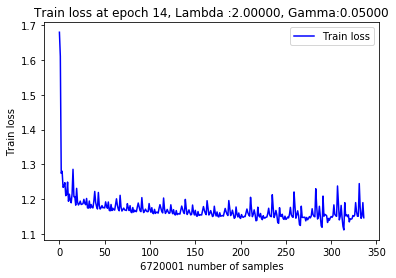

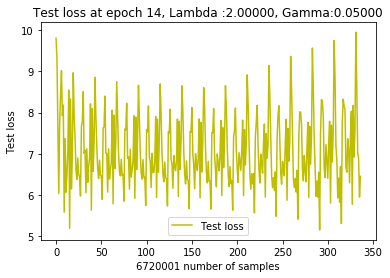

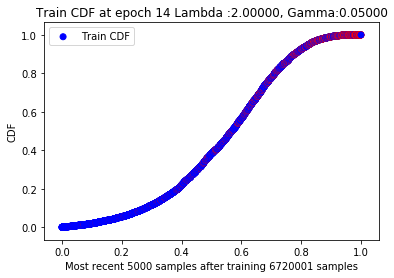

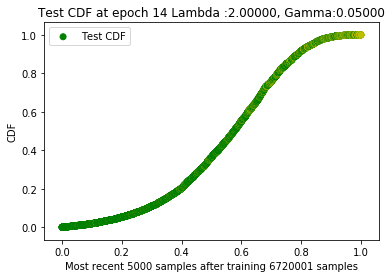

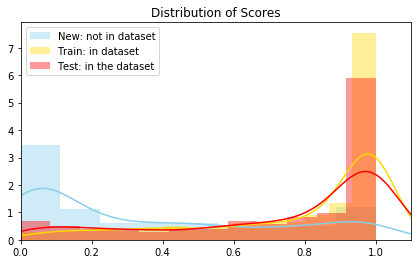

  0%|          | 5/480000 [01:11<6647:05:44, 49.85s/it]

New score:  0.3326104
Train score:  0.7699125
Test score:  0.7391691


 42%|████▏     | 200000/480000 [2:16:45<5:45:18, 13.51it/s]   

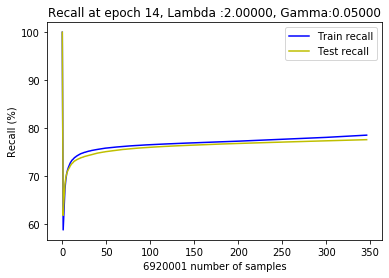

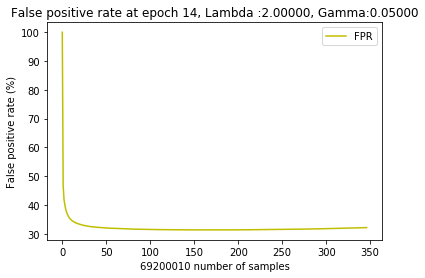

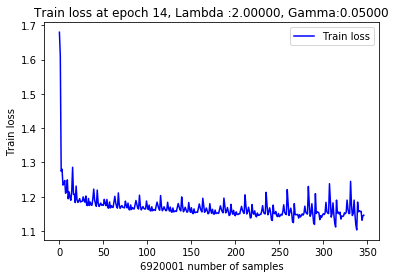

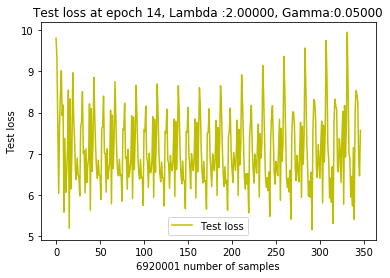

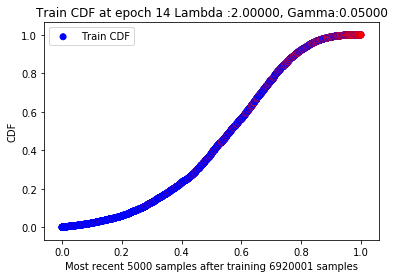

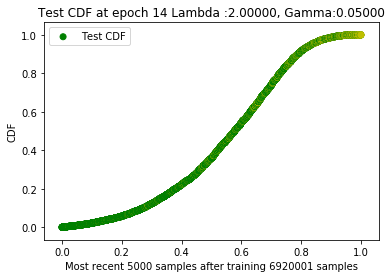

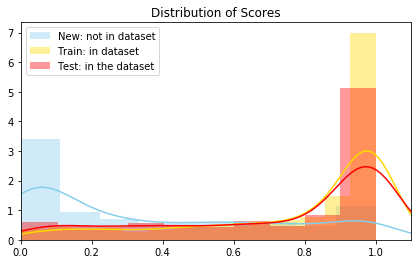

 42%|████▏     | 200003/480000 [2:18:41<1897:34:17, 24.40s/it]

New score:  0.38939953
Train score:  0.7929377
Test score:  0.740486


 43%|████▎     | 207027/480000 [2:26:17<5:32:20, 13.69it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 46%|████▋     | 222397/480000 [2:44:44<3:52:12, 18.49it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 48%|████▊     | 231970/480000 [2:55:00<4:47:08, 14.40it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config

 20%|█▉        | 95865/480000 [1:02:24<3:12:01, 33.34it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 25%|██▌       | 121823/480000 [1:20:04<3:24:14, 29.23it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 28%|██▊       | 136714/480000 [1:28:57<3:57:16, 24.11it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config vari

 14%|█▍        | 67142/480000 [44:19<5:17:31, 21.67it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 17%|█▋        | 80753/480000 [53:33<3:20:40, 33.16it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 22%|██▏       | 107523/480000 [1:10:32<5:06:49, 20.23it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable

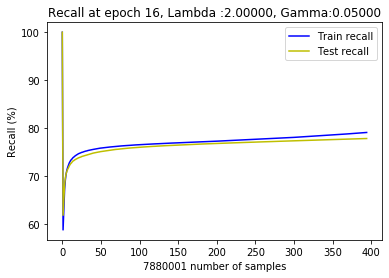

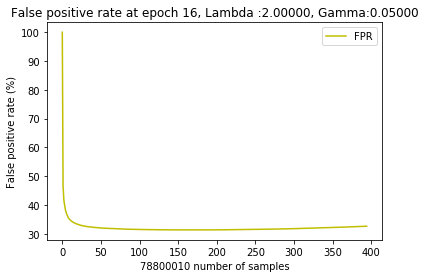

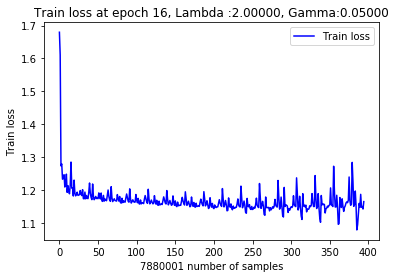

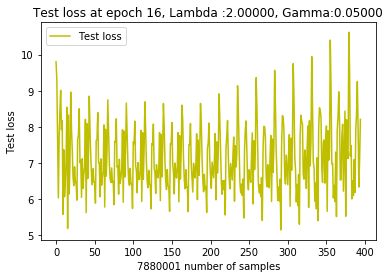

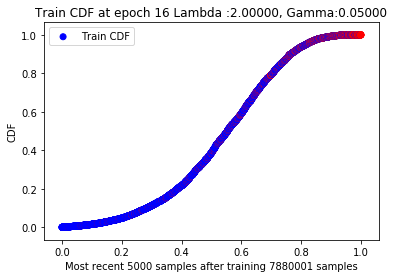

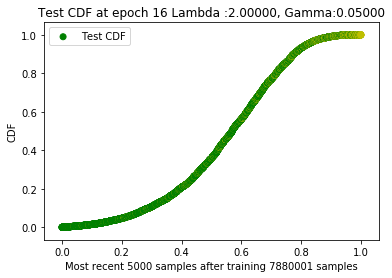

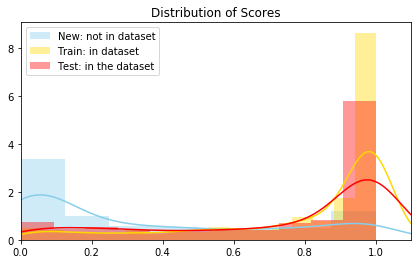

 42%|████▏     | 200005/480000 [2:11:29<421:07:15,  5.41s/it]

New score:  0.35455543
Train score:  0.80496365
Test score:  0.73328674


 42%|████▏     | 202875/480000 [2:13:12<2:22:40, 32.37it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 48%|████▊     | 230215/480000 [2:30:40<3:06:40, 22.30it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 51%|█████     | 243542/480000 [2:39:46<2:15:36, 29.06it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config 

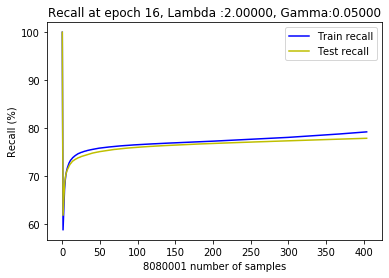

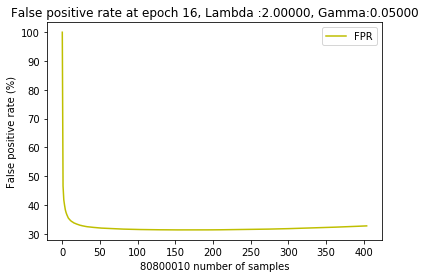

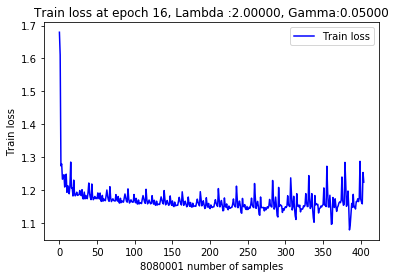

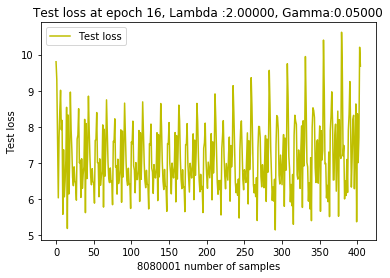

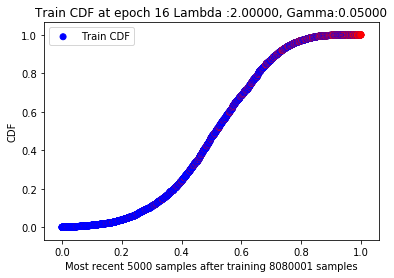

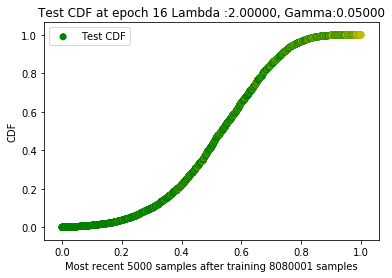

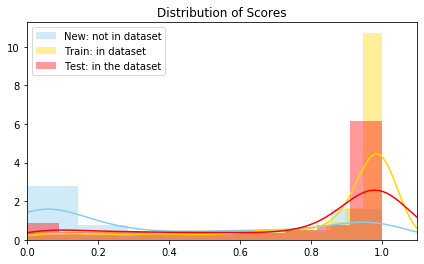

 83%|████████▎ | 400005/480000 [4:21:39<86:15:04,  3.88s/it] 

New score:  0.38637358
Train score:  0.8334658
Test score:  0.78409153


 85%|████████▌ | 408287/480000 [4:26:35<40:06, 29.80it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 88%|████████▊ | 421319/480000 [4:35:33<43:31, 22.47it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 94%|█████████▎| 449411/480000 [4:53:16<25:48, 19.75it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config var

 80%|███████▉  | 383278/480000 [4:10:32<53:30, 30.12it/s]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 82%|████████▏ | 395437/480000 [4:17:44<46:43, 30.16it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 88%|████████▊ | 424516/480000 [4:37:28<46:03, 20.08it/s]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config v

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  18  with learning rate:  [0.03151247048623045]


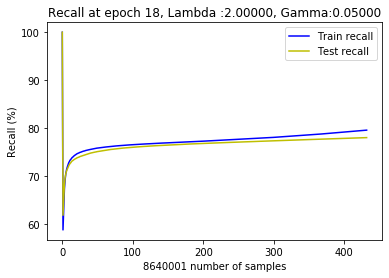

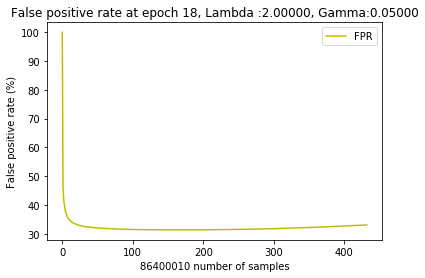

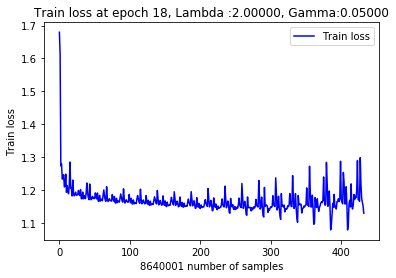

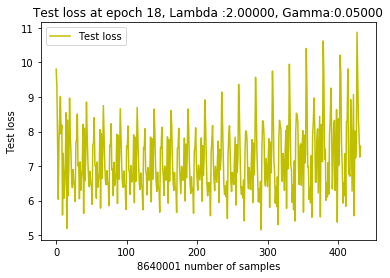

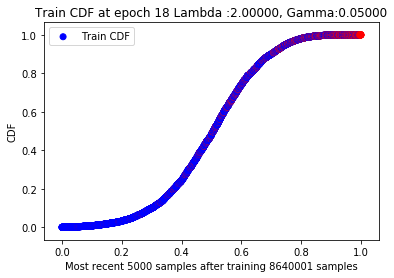

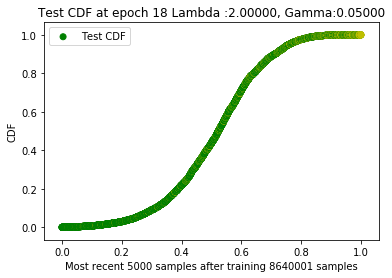

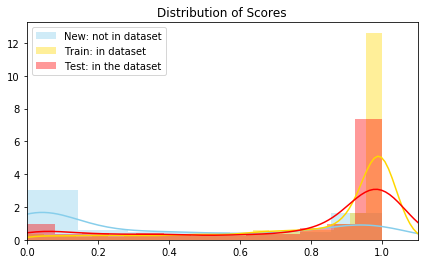

  0%|          | 5/480000 [01:12<6735:42:00, 50.52s/it]

New score:  0.39363313
Train score:  0.8236376
Test score:  0.7678164


 42%|████▏     | 199998/480000 [2:01:40<2:14:38, 34.66it/s]  

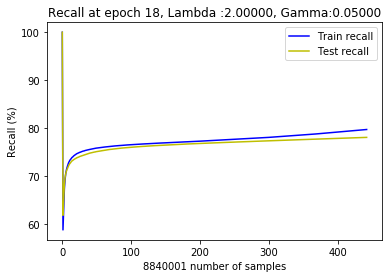

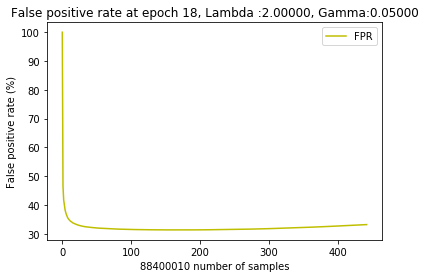

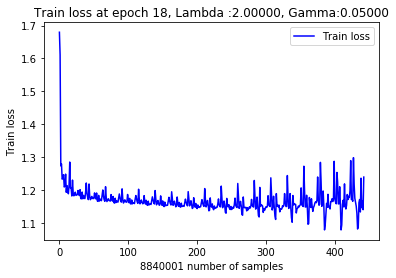

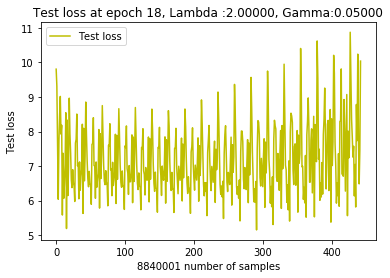

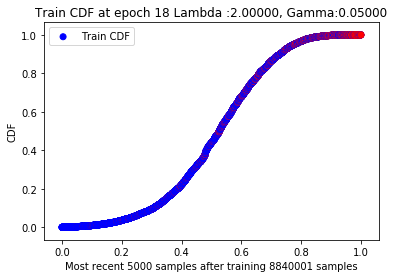

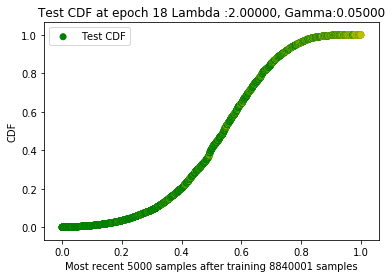

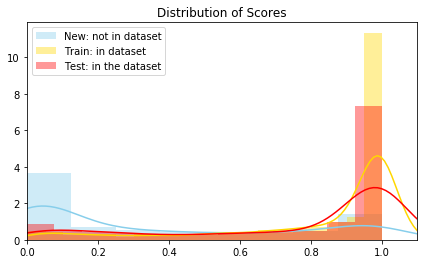

 42%|████▏     | 200005/480000 [2:02:33<384:58:54,  4.95s/it]

New score:  0.3346381
Train score:  0.81647325
Test score:  0.7530371


 77%|███████▋  | 368607/480000 [4:24:50<1:49:51, 16.90it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 83%|████████▎ | 396272/480000 [4:51:19<1:10:07, 19.90it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 88%|████████▊ | 423578/480000 [5:19:29<49:33, 18.98it/s]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config v

 61%|██████    | 291986/480000 [4:47:44<2:35:38, 20.13it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 63%|██████▎   | 302268/480000 [4:57:55<1:53:59, 25.98it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 68%|██████▊   | 328005/480000 [5:21:11<3:31:20, 11.99it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config var

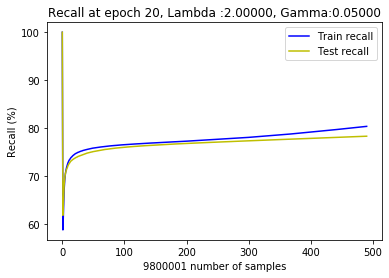

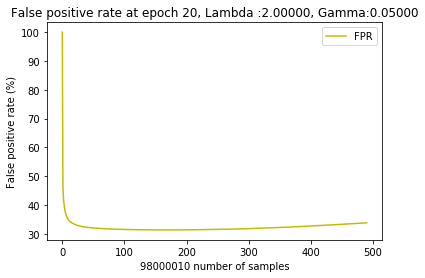

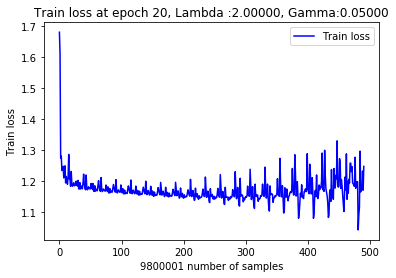

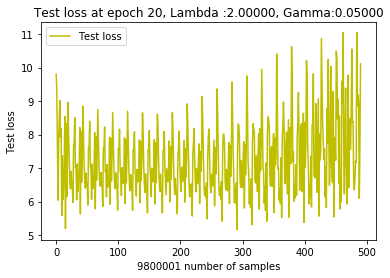

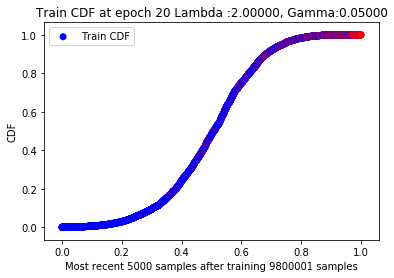

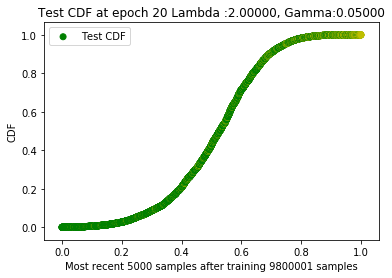

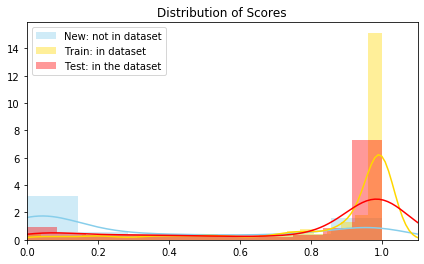

 42%|████▏     | 200003/480000 [3:17:25<1662:27:27, 21.37s/it]

New score:  0.35391176
Train score:  0.8454962
Test score:  0.7595562


 42%|████▏     | 203468/480000 [3:20:32<4:39:35, 16.48it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 48%|████▊     | 232750/480000 [3:48:31<3:42:43, 18.50it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 55%|█████▍    | 262299/480000 [4:18:16<3:01:08, 20.03it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config 

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  21  with learning rate:  [0.027018004383131834]


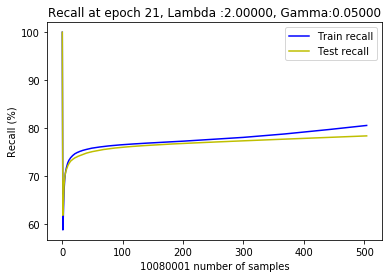

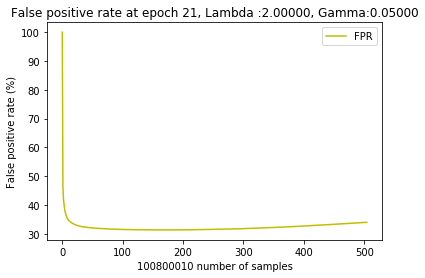

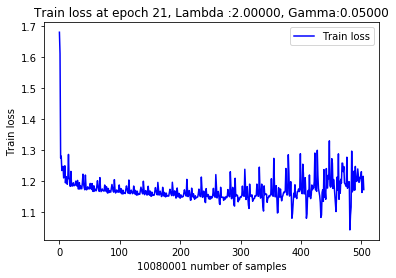

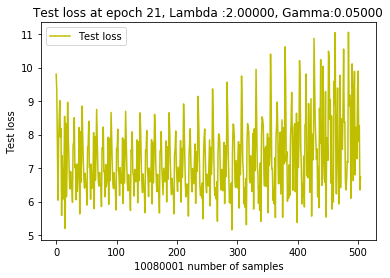

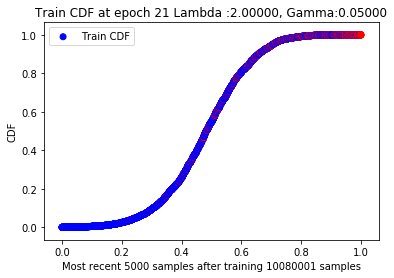

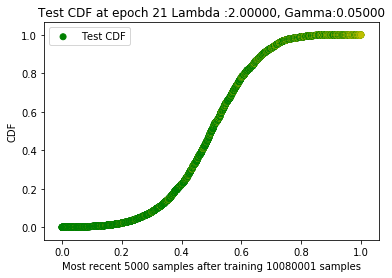

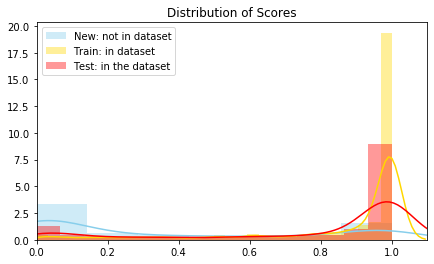

  0%|          | 5/480000 [01:41<9483:57:21, 71.13s/it]  

New score:  0.3452334
Train score:  0.8405362
Test score:  0.7813222


  1%|          | 4968/480000 [06:07<6:07:53, 21.52it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  2%|▏         | 10717/480000 [10:45<5:05:50, 25.57it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  9%|▊         | 41522/480000 [35:46<5:10:18, 23.55it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--

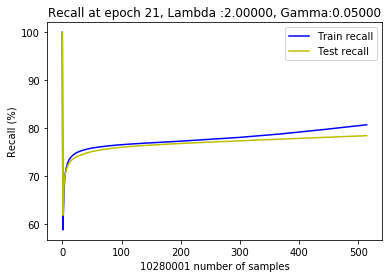

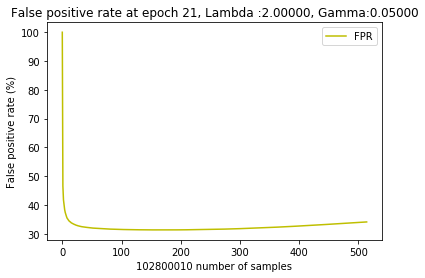

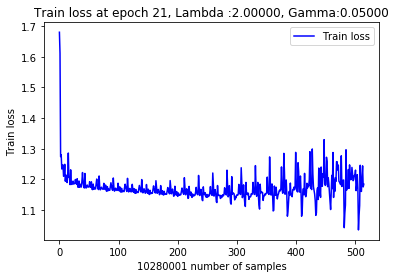

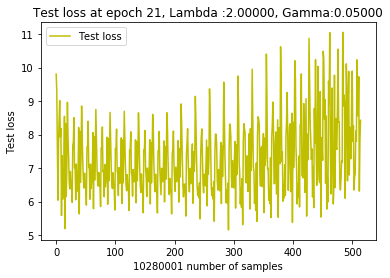

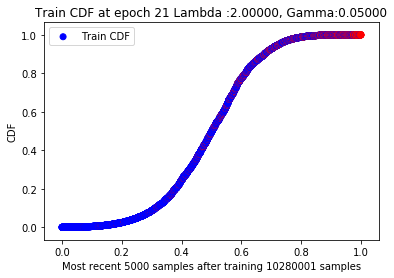

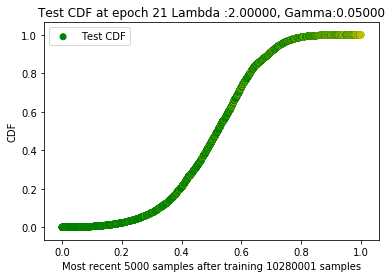

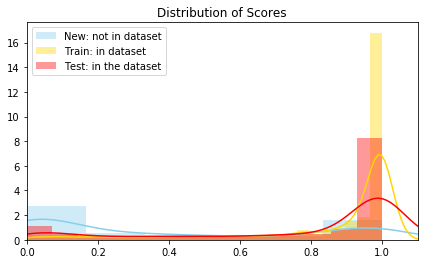

 42%|████▏     | 200005/480000 [2:41:46<1435:55:01, 18.46s/it]

New score:  0.40980667
Train score:  0.86163086
Test score:  0.7750099


 83%|████████▎ | 399998/480000 [5:19:00<50:01, 26.66it/s]     

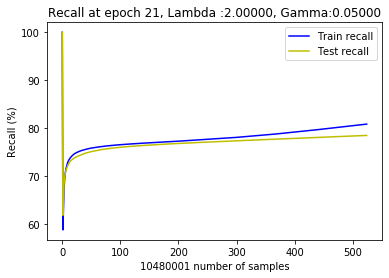

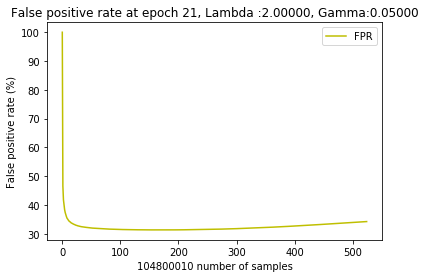

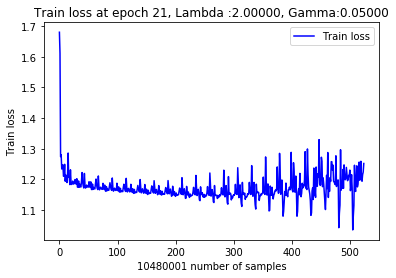

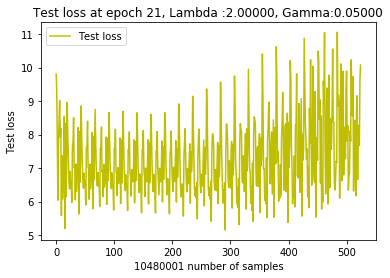

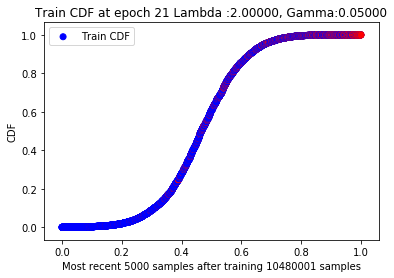

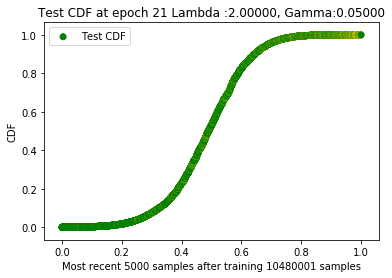

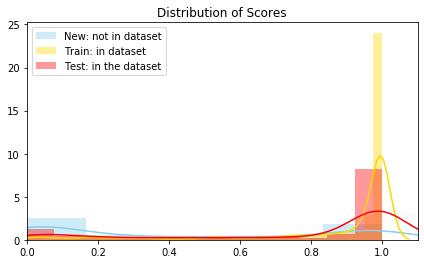

 83%|████████▎ | 400004/480000 [5:20:16<138:34:22,  6.24s/it]

New score:  0.4205844
Train score:  0.8727625
Test score:  0.81220424


  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  22  with learning rate:  [0.028440004613822983]


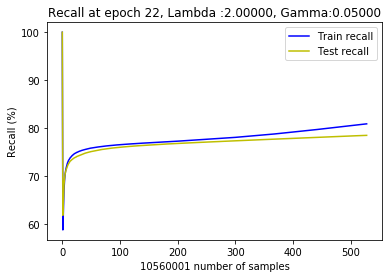

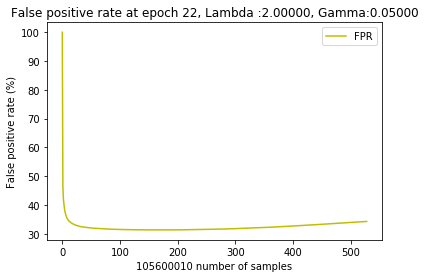

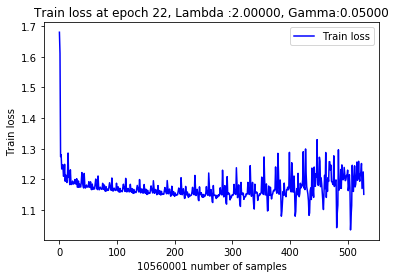

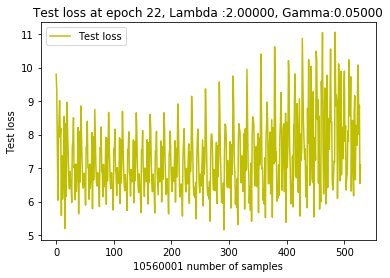

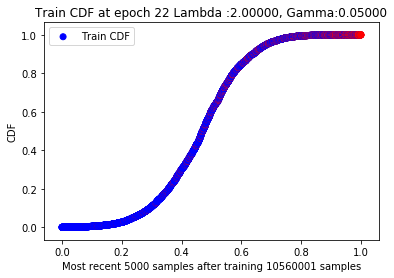

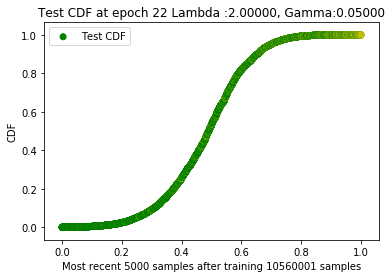

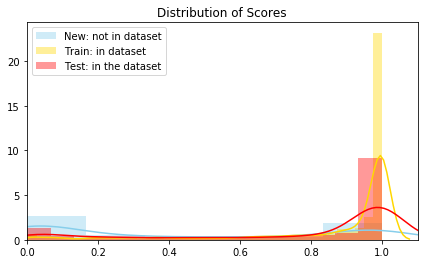

  0%|          | 3/480000 [01:28<8270:41:50, 62.03s/it] 

New score:  0.36532623
Train score:  0.85030276
Test score:  0.7867523


 44%|████▎     | 209730/480000 [2:44:10<5:47:29, 12.96it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 48%|████▊     | 229864/480000 [3:02:54<3:21:42, 20.67it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 54%|█████▎    | 257606/480000 [3:28:05<4:07:23, 14.98it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config var

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  23  with learning rate:  [0.02566710416397524]


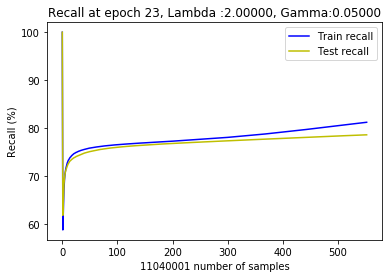

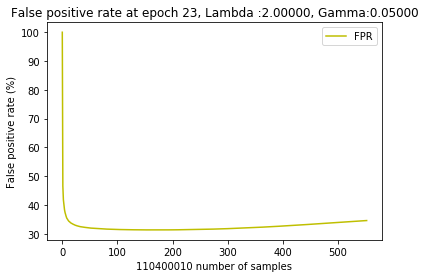

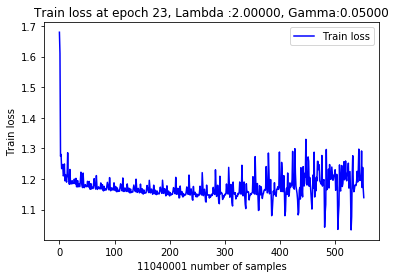

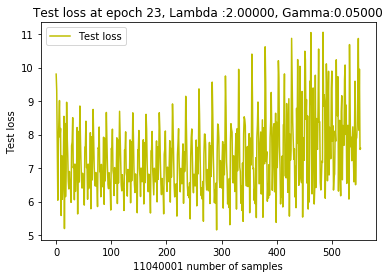

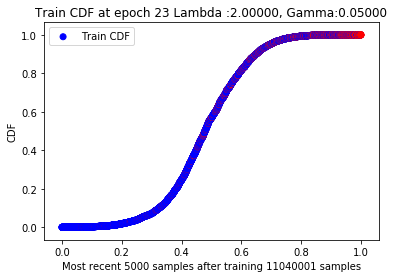

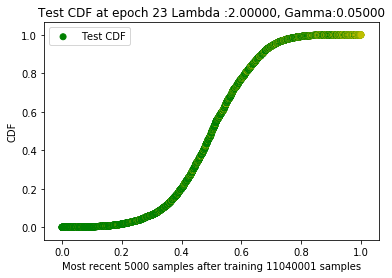

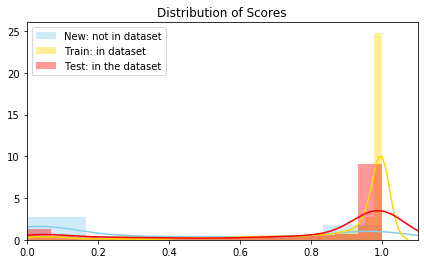

  0%|          | 6/480000 [01:18<7356:48:16, 55.18s/it] 

New score:  0.39235473
Train score:  0.85722166
Test score:  0.77990514


  2%|▏         | 10010/480000 [07:35<4:29:31, 29.06it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  8%|▊         | 39801/480000 [27:41<4:06:07, 29.81it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 14%|█▍        | 69496/480000 [48:49<3:39:42, 31.14it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--

 47%|████▋     | 227693/480000 [2:39:14<2:39:05, 26.43it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 54%|█████▎    | 257031/480000 [2:59:06<2:43:31, 22.72it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 60%|█████▉    | 286363/480000 [3:20:12<2:06:48, 25.45it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config v

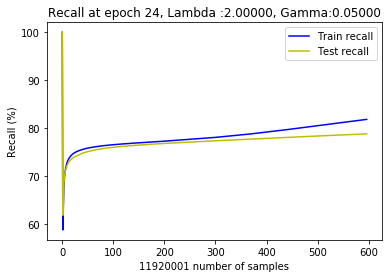

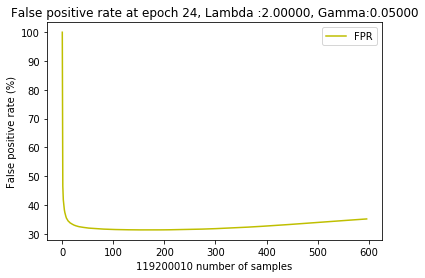

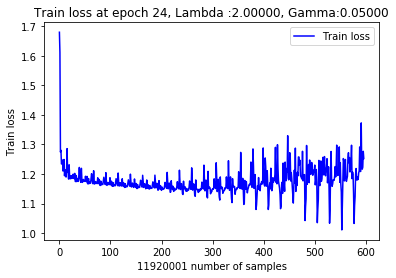

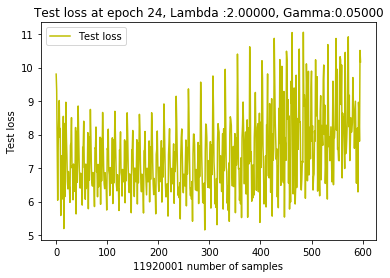

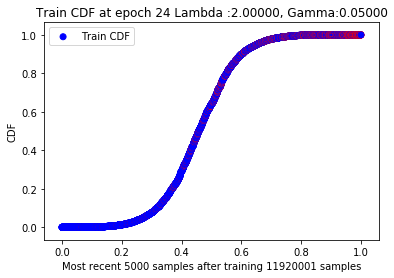

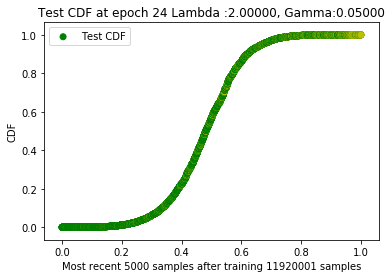

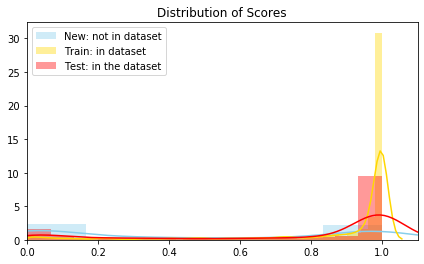

 83%|████████▎ | 400005/480000 [4:39:46<183:36:46,  8.26s/it]

New score:  0.4011983
Train score:  0.8788954
Test score:  0.81471324


 85%|████████▌ | 409386/480000 [4:45:33<39:35, 29.73it/s]    IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 93%|█████████▎| 446073/480000 [5:09:38<13:47, 41.02it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 99%|█████████▉| 476876/480000 [5:29:04<01:55, 27.14it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config vari

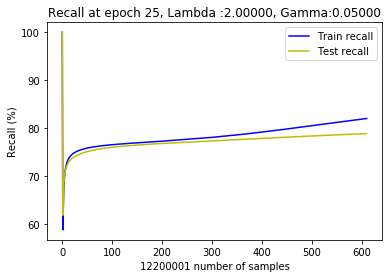

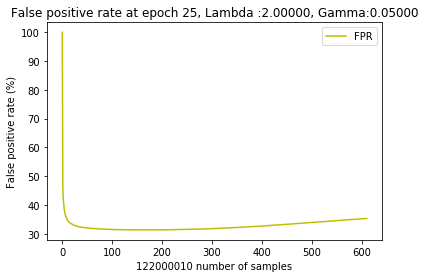

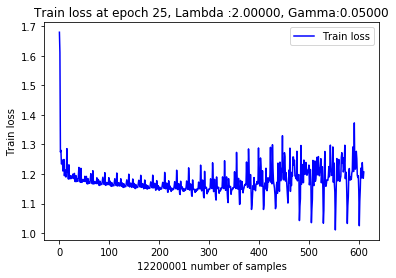

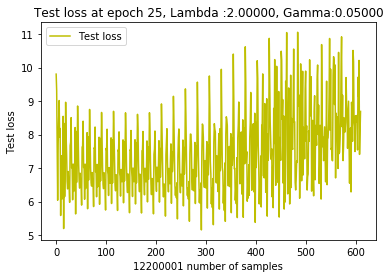

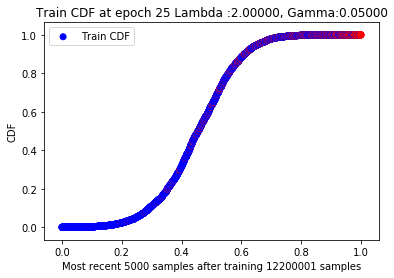

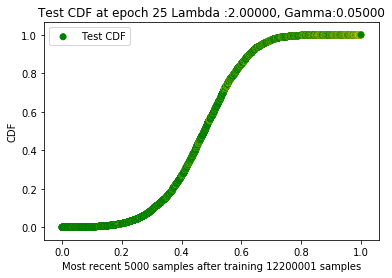

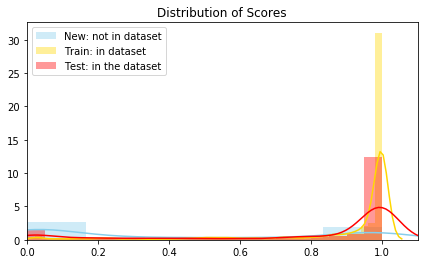

 42%|████▏     | 200006/480000 [1:42:10<177:50:21,  2.29s/it]

New score:  0.4290464
Train score:  0.8872986
Test score:  0.8085822


 45%|████▍     | 214836/480000 [1:48:21<1:35:21, 46.35it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 53%|█████▎    | 252861/480000 [2:05:58<1:21:27, 46.47it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 60%|██████    | 290316/480000 [2:23:24<1:29:24, 35.36it/s]  IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config

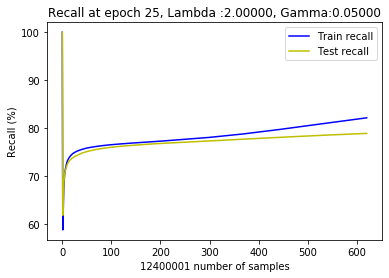

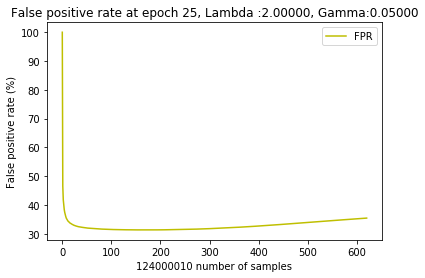

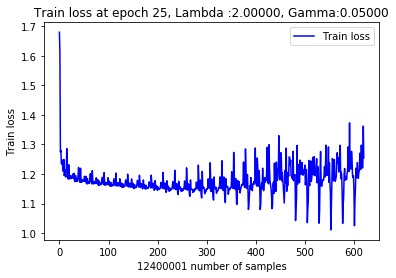

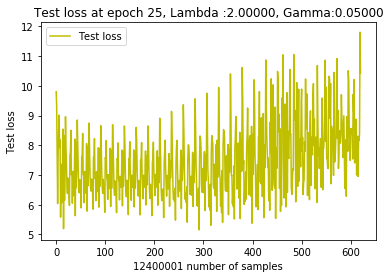

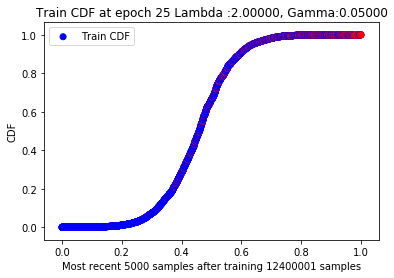

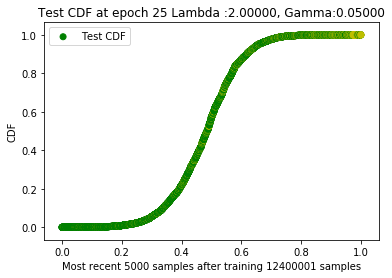

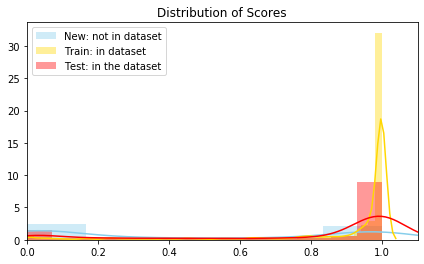

 83%|████████▎ | 400006/480000 [3:14:26<50:46:14,  2.28s/it]

New score:  0.4120769
Train score:  0.8884649
Test score:  0.8094634


 84%|████████▎ | 401121/480000 [3:14:54<30:09, 43.59it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 93%|█████████▎| 445726/480000 [3:35:18<13:34, 42.07it/s]   IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  0%|          | 0/480000 [00:00<?, ?it/s]

Saving to:  model_checkpoints/ConvNetSimpleBoost/05132020.pth
Training Epoch:  26  with learning rate:  [0.02566710416397524]


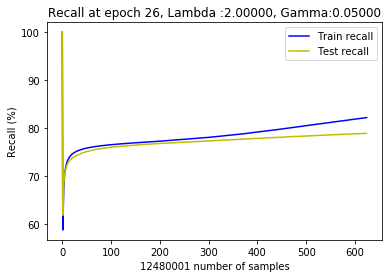

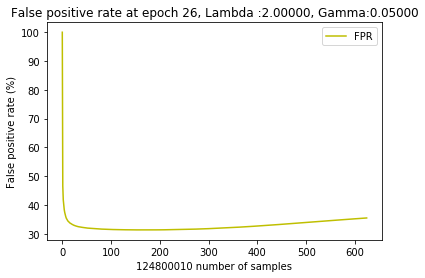

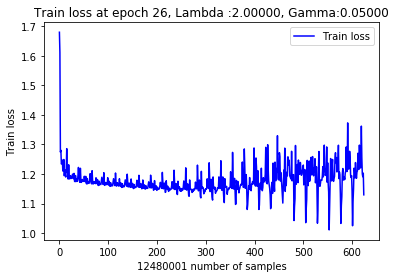

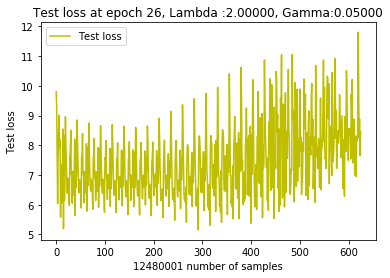

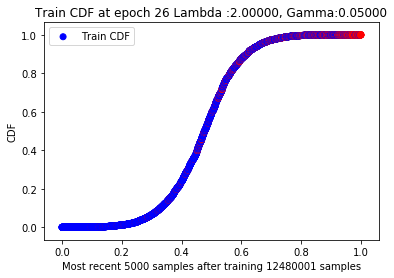

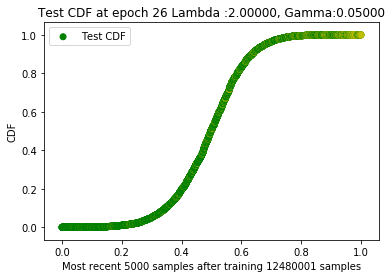

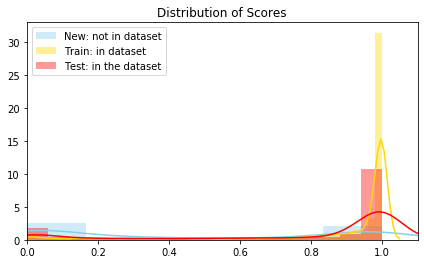

  0%|          | 6/480000 [00:54<5069:40:37, 38.02s/it]

New score:  0.4529118
Train score:  0.8686316
Test score:  0.7887246


  1%|          | 5051/480000 [02:58<2:47:39, 47.21it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

  7%|▋         | 31743/480000 [23:53<9:42:56, 12.82it/s] IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

 10%|▉         | 46997/480000 [48:36<12:36:46,  9.54it/s]IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--

In [ ]:
model = ConvNetSimpleBoost()
model.to(device)
model_name = model.name
checkpoint = None
save_path = 'model_checkpoints/%s/05132020.pth' %model_name

sgd(num_epochs=NUM_EPOCHS,
    batch_size=BATCH_SIZE,
    l=LAMBDA, 
    gamma=GAMMA,
    run_from_checkpoint=checkpoint, 
    save_checkpoints=save_path)